# Residential Energy Appliance Classification

Programming Language: R 3.5.1 in Jupyter Notebook

## Table of Contents

1. [Initial Settings](#sec_1)    
2. [Import Libraries](#sec_2)    
3. [Exploratory Analysis](#sec_3)   
3.1 [Description of the features](#sec_3.1)                                    
3.2 [Correlation between numerical features](#sec_3.2)                                          
3.3 [Behavior of categorical features](#sec_3.3)                                                       
3.4 [Balance of the labels](#sec_3.4)
4. [Data Wrangling and Feature Extraction](#sec_4)                                                   
5. [Feature Selection](#sec_5)                                       
5.1 [Chi-Square](#sec_5.1)                                       
5.2 [Fischer](#sec_5.2)                                            
5.3 [Final Selection](#sec_5.3)                                               
6. [Stratified K-fold Cross Validation](#sec_6)                                  
6.1 [Model 1: KNN](#sec_6.1)                                                
6.2 [Model 2: Logistic Regression](#sec_6.2)                                       
6.4 [Model 3: Gradient Boosting](#sec_6.3) 
7. [Conclusion](#sec_7)                                                         
7.1 [Best Models](#sec_7.1) 

## 1. Initial Settings <a class="anchor" id="sec_1"></a>

### Memory Limit 
By defaul the memory limit of our Jupyter notebook is to low

In [1]:
memory.size()

[1] 45.39

As we are going to build complex models, that will use huge amount of data. We will change these parameter to prevent the notebook to crash.

In [2]:
memory.limit(100000)

[1] 1e+05

### Warnings
There some lines of code that could show some warnings (not errors!) about the algorithm. These warning could be anoying when running the notebook. That is why we proceed to remove them.

In [2]:
options(warn=-1)

## 2. Import Libraries <a class="anchor" id="sec_2"></a>

In [5]:
# install.packages('mltools') # Run this line the first time you run the notebook
library(mltools)
# install.packages('data.table') # Run this line the first time you run the notebook
library(data.table)
# install.packages('tidyverse') # Run this line the first time you run the notebook
library(tidyverse)
# install.packages('tsfeatures') # Run this line the first time you run the notebook
library(tsfeatures)
# install.packages('zoo') # Run this line the first time you run the notebook
library(zoo)
# install.packages('Biocomb') # Run this line the first time you run the notebook
library(Biocomb)
# install.packages('Rdimtools') # Run this line the first time you run the notebook
library(Rdimtools)
# install.packages('splitTools') # Run this line the first time you run the notebook
library(splitTools)
# install.packages('MLmetrics') # Run this line the first time you run the notebook
library(MLmetrics)
# install.packages('graphics') # Run this line the first time you run the notebook
library(graphics)
# install.packages('class') # Run this line the first time you run the notebook
library(class)
# install.packages('caret') # Run this line the first time you run the notebook
library(caret)
# install.packages('xgboost') # Run this line the first time you run the notebook
library(xgboost)
# install.packages('lattice') # Run this line the first time you run the notebook
library(lattice)
# install.packages('scales') # Run this line the first time you run the notebook
library(scales)

## 3. Exploratory Analysis <a class="anchor" id="sec_3"></a>

### Import Datasets

In [4]:
train.dataset <- read.csv("./data/train.csv")
test.dataset <- read.csv("./data/test.csv")
head(train.dataset)

X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
105541,2.245,0,0,0,0,0,0,Sun,0.987,0.987,6.215,3.074549,0.6788858,0.05290291,0.9940715
105542,2.259,0,0,0,0,0,0,Sun,0.014,0.014,6.215,3.172867,0.6674503,0.05482926,0.9941540
105543,2.269,0,0,0,0,0,0,Sun,0.010,0.010,6.215,3.270112,0.6477770,0.05699074,0.9942200
105544,2.268,0,0,0,0,0,0,Sun,-0.001,0.001,6.215,3.303763,0.6292270,0.05760593,0.9941497
105545,2.270,0,0,0,0,0,0,Sun,0.002,0.002,6.215,3.302744,0.6212951,0.08263997,0.9940406
105546,2.259,0,0,0,0,0,0,Sun,-0.011,0.011,6.215,3.298258,0.6269564,0.08978753,0.9939864


### 3.1 Description of the features <a class="anchor" id="sec_3.1"></a>

|Feature  |Type       |Sub-type  |Description                                                                            |
|:-:|:-:|:-:|:-|
|X     |Numerical  |Discrete   |Each Record has been assigned to a unique number.|
|load      |Numerical  |Continuous| The amount of electricity load.  |
|ac  |Numerical  |Discrete  |The value indicates whether ac is on or off. |
|ev |Numerical  |Discrete  |The value indicates whether ev is on or off. |
|oven|Numerical  |Discrete|The value indicates whether oven is on or off.    |
|wash|Numerical |Discrete   |The value indicates whether wash is on or off          |
|dryer  |Numerical|Discrete   |The value indicates whether dryer is on or off.     |
|hourofday   |Numerical  |Discrete|The value indicates the hour of the day which data is recorded.            |
|dayofweek      |Categorical|Nominal   |The value indicates the day of the week which data is recorded.
|dif   |Numerical|Continuous  |Difference between two sequential load data points..                                     |
|absdif   |Numerical|Continuous  |Absolute value of dif.                                     |
|max    |Numerical|Continuous  |The maximum load over a neighborhood time window of 60 minutes.|
|var   |Numerical|Continuous |Variance of load over a neighborhood time window of 30 minutes around each load data point. |
|entropy   |Numerical|Continuous |The Shannon entropy5 that measures the "forecastability" of a time series data.
|nonlinear   |Numerical|Continuous |The nonlinearity coeffcient6 is used in Terasvirta's nonlinearity test.
|hurst   |Numerical|Continuous |The hurst7 which is a measure of the long-term memory of a time series.


### 3.2 Correlation between numerical features <a class="anchor" id="sec_3.2"></a>
In the following plot we are going to plot the correlation between numerical features, removing labels and categorical columns as `dayofweek` and `hourofday`

In [7]:
cor_df <- train.dataset[,-which(sapply(train.dataset, class) == "factor")] # Remove factor columns
cor_df <- cor_df[,-c(1,3,4,5,6,7)] # Remove labels and sequence of lines

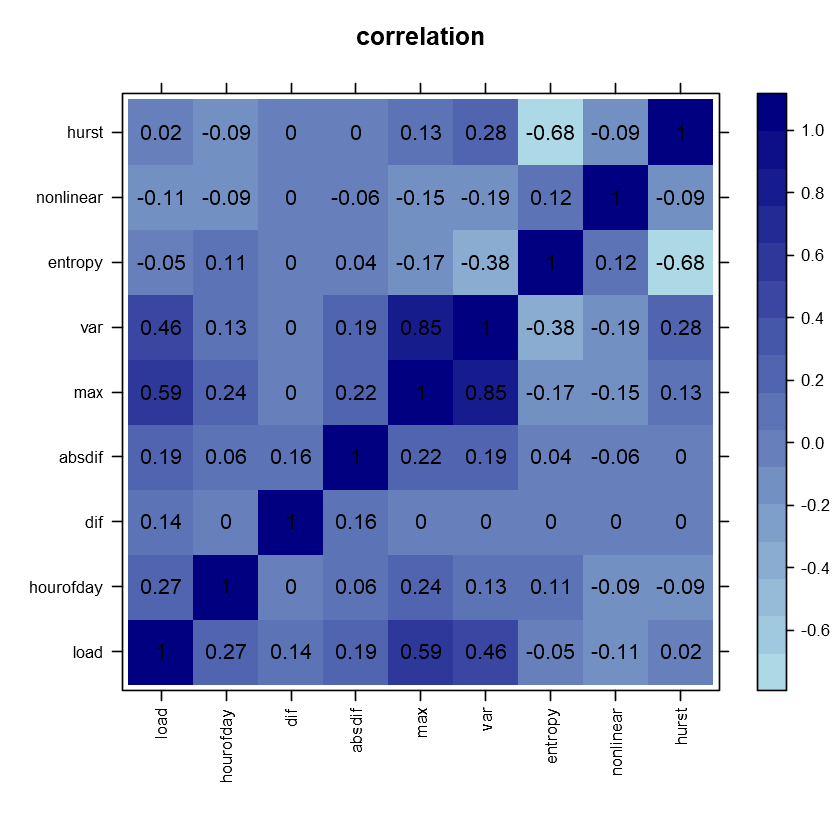

In [8]:
#Define you own panel
myPanel <- function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x, y, round(z, 2))
}
#Define the color scheme
cols = colorRampPalette(c("lightblue","navyblue"))
#Plot the correlation matrix.
levelplot(cor(cor_df), col.regions = cols(100), 
          main = "correlation", xlab = NULL, ylab = NULL, scales = list(x = list(rot = 90)), panel = myPanel)

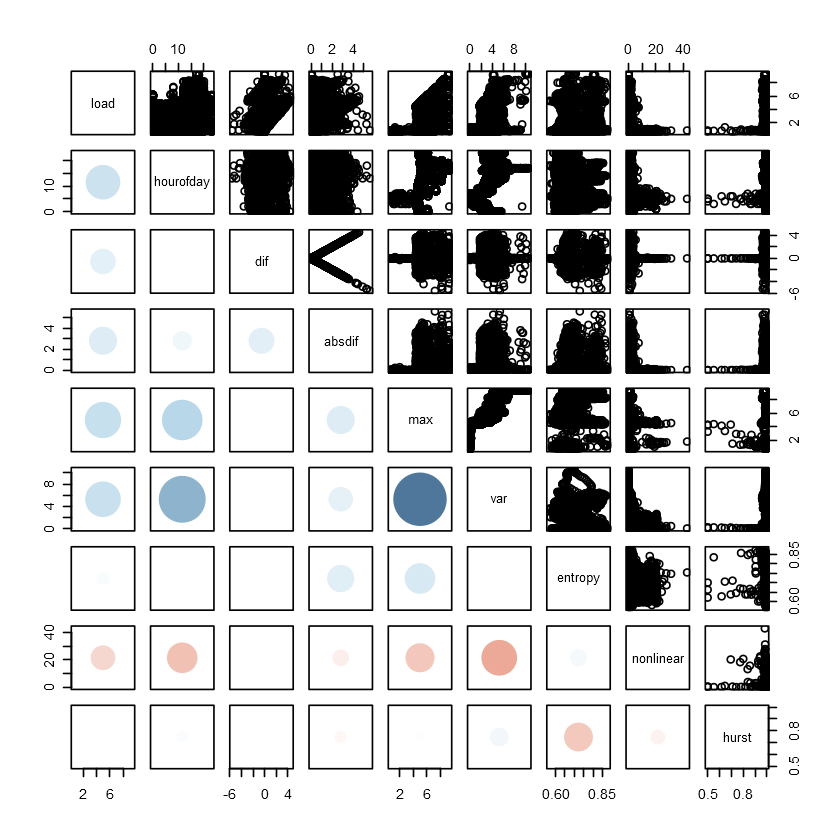

In [10]:
# DIY correlation plot
# http://stackoverflow.com/questions/31709982/how-to-plot-in-r-a-correlogram-on-top-of-a-correlation-matrix
# there's some truth to the quote that modern programming is often stitching together pieces from SO 

colorRange <- c('#69091e', '#e37f65', 'white', '#aed2e6', '#042f60')
## colorRamp() returns a function which takes as an argument a number
## on [0,1] and returns a color in the gradient in colorRange
myColorRampFunc <- colorRamp(colorRange)

panel.cor <- function(w, z, ...) {
    correlation <- cor(w, z)

    ## because the func needs [0,1] and cor gives [-1,1], we need to shift and scale it
    col <- rgb(myColorRampFunc((1 + correlation) / 2 ) / 255 )

    ## square it to avoid visual bias due to "area vs diameter"
    radius <- sqrt(abs(correlation))
    radians <- seq(0, 2*pi, len = 50) # 50 is arbitrary
    x <- radius * cos(radians)
    y <- radius * sin(radians)
    ## make them full loops
    x <- c(x, tail(x,n=1))
    y <- c(y, tail(y,n=1))

    ## trick: "don't create a new plot" thing by following the
    ## advice here: http://www.r-bloggers.com/multiple-y-axis-in-a-r-plot/
    ## This allows
    par(new=TRUE)
    plot(0, type='n', xlim=c(-1,1), ylim=c(-1,1), axes=FALSE, asp=1)
    polygon(x, y, border=col, col=col)
}

# exclude the categorical and target columns
pairs(cor_df, lower.panel=panel.cor)

It can be seen that there is a relatively high positive correlation between “max” and “var” features by 0.85 which might lead to multicollinearity and it needs to be checked. 

### 3.3 Behavior of categorical features <a class="anchor" id="sec_3.3"></a>

#### Hour of the day

`geom_smooth()` using formula 'y ~ x'


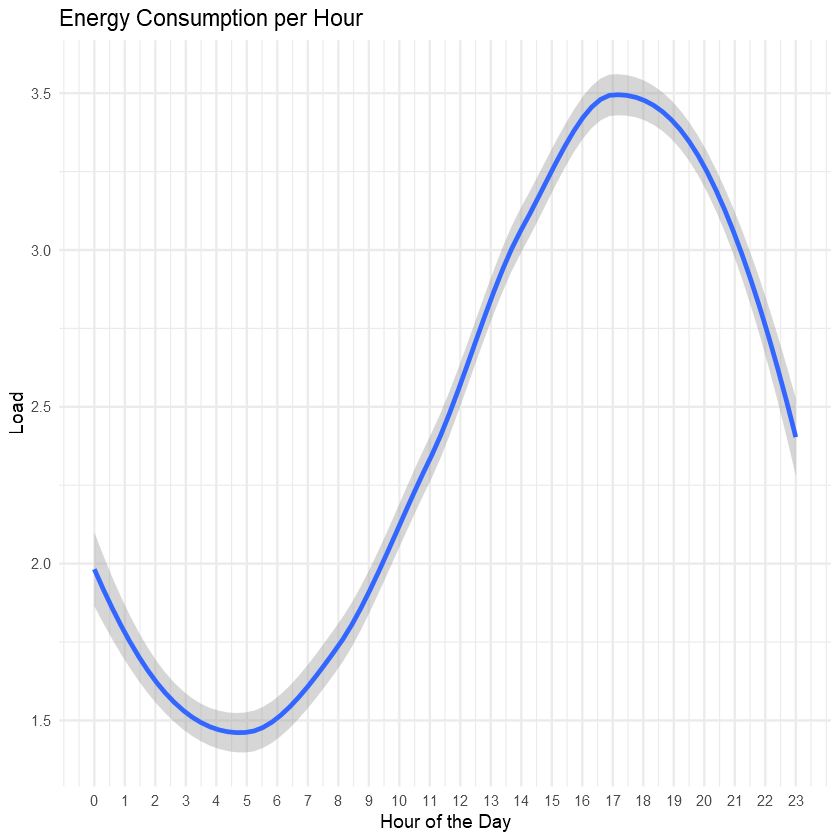

In [11]:
ggplot(train.dataset, aes(x=as.numeric(hourofday), y=load)) + geom_smooth(method="loess") + 
xlab("Hour of the Day") + ylab("Load") + ggtitle("Energy Consumption per Hour") + 
scale_x_continuous(breaks = seq(0, 23, 1)) + theme_minimal()

There is a clear behaviour for electricity consumption during different hours of the day which leads us to think that people tend to use the appliances more during the time they are at home from 16 to 21.

#### Day of the week

No summary function supplied, defaulting to `mean_se()`


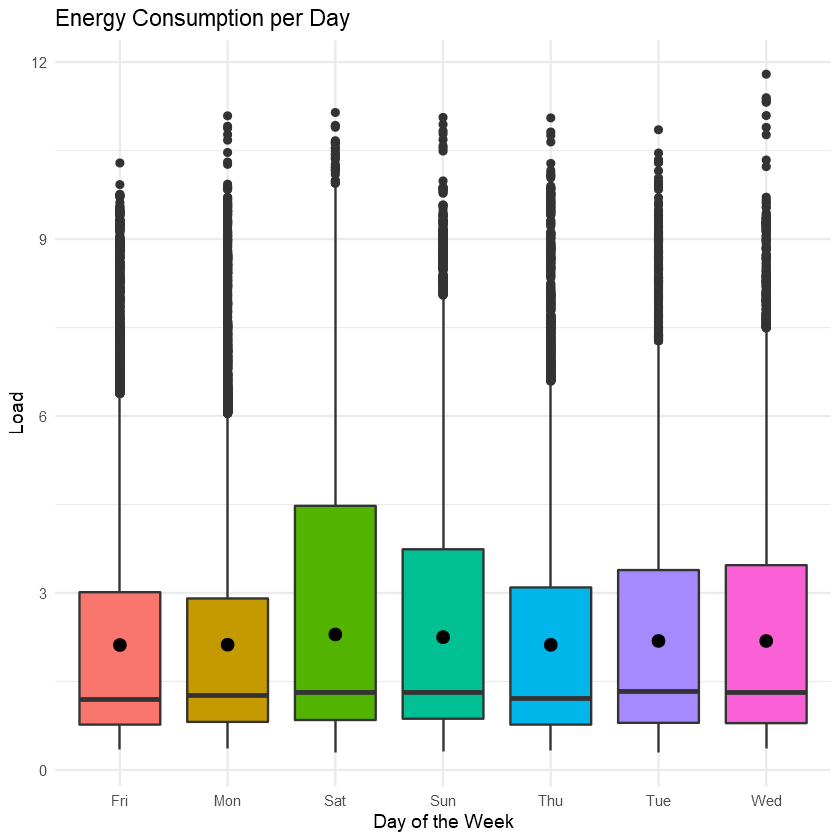

In [29]:
ggplot(data=train.dataset, aes(x=dayofweek, y=load, fill=dayofweek)) + geom_boxplot() + stat_summary() + 
xlab("Day of the Week") + ylab("Load") + ggtitle("Energy Consumption per Day") + 
theme_minimal() + theme(legend.position = "none")

There is a clear behaviour for electricity consumption during different days of the week which leads us to think that people tend to use the appliances more during weekends.

### 3.4 Balance of the labels <a class="anchor" id="sec_3.4"></a>

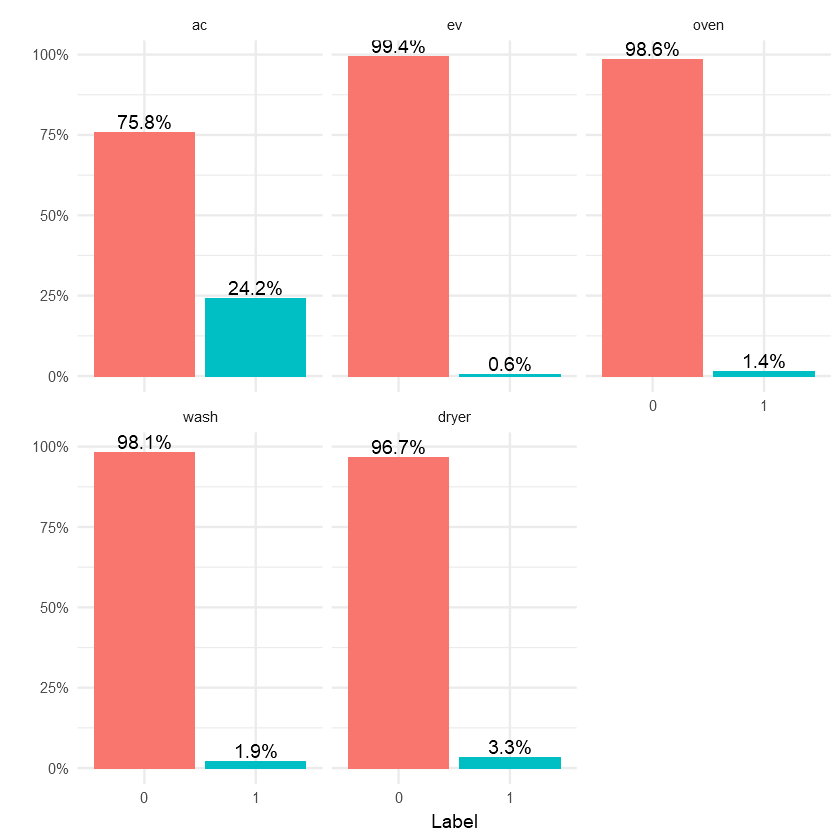

In [30]:
labels <- train.dataset[,c(3,4,5,6,7)]  # Get all the labels of the datset
labels['auxiliary'] <- "auxiliary"  # Build a new columns as an auxiliary to do melt
balance <- melt(labels, id=c('auxiliary')) # Balance dataset 

# Plot the balance of labels 
ggplot(balance, aes(x = as.factor(value), fill=as.factor(value))) +  
        geom_bar(aes(y = (..count..)*5/sum(..count..))) + 
        geom_text(aes(y = ((..count..)*5/sum(..count..)), label = scales::percent((..count..)*5/sum(..count..))), 
                  stat = "count", vjust = -0.25) + scale_y_continuous(labels=percent) + ylab(' ') + xlab('Label') + 
                    facet_wrap(~variable) + theme_minimal() + theme(legend.position = "none")

## 4. Data Wrangling and Feature Extraction <a class="anchor" id="sec_4"></a>

### Convert some columns as factors

In [6]:
train.dataset$hourofday = as.factor(train.dataset$hourofday)
train.dataset$dayofweek = as.factor(train.dataset$dayofweek)

test.dataset$hourofday = as.factor(test.dataset$hourofday)
test.dataset$dayofweek = as.factor(test.dataset$dayofweek)

### One hot encoding for Categorical columns

In [34]:
# ohe for catgorical values
train.data = one_hot(as.data.table(train.dataset), cols = c('dayofweek','hourofday'))
test.data = one_hot(as.data.table(test.dataset), cols = c('dayofweek','hourofday'))

### Feature Extraction

In [35]:
# using the tsfeatures library to make new features using windowing
get_features <- function(df,N){
    df <- df %>% 
        mutate("crossing_points_{N}" := rollapply(load,N,crossing_points  ,fill=0)) %>%
        mutate("flat_spots_{N}" := rollapply(load,N,flat_spots  ,fill=0))%>%
        mutate("firstmin_ac_{N}" := rollapply(load,N,firstmin_ac   ,fill=0))%>%
        mutate("firstzero_ac_{N}" := rollapply(load,N,firstzero_ac   ,fill=0))%>%
        mutate("trev_num_{N}" := rollapply(load,N,trev_num   ,fill=0))%>%
        mutate("std1st_der_{N}" := rollapply(load,N,std1st_der   ,fill=0))

    return(df)
}

In [36]:
# make new features with window = 30
train.df.new.feat = get_features(train.data,30)
test.df.new.feat = get_features(test.data,30)

### Normalize the data
We normalixe the data using min-max transformation to bring the data into same scale. This will help improve on training time later.

In [40]:
normalize <- function(x) {
  return ((x - min(x)) / (max(x) - min(x)))
}

In [41]:
# prepare the train and test data
train.df.max.min <- as.data.frame(lapply(train.df.new.feat, normalize))
test.df.max.min <- as.data.frame(lapply(test.df.new.feat, normalize))

### Final Results

In [42]:
head(train.df.max.min)

X,load,ac,ev,oven,wash,dryer,hourofday_0,hourofday_1,hourofday_2,...,var,entropy,nonlinear,hurst,crossing_points_30,flat_spots_30,firstmin_ac_30,firstzero_ac_30,trev_num_30,std1st_der_30
0.000000e+00,0.1693633,0,0,0,0,0,1,0,0,...,0.1881049,0.6788945,0.0009687095,0.9972604,0,0,0,0,0.5122471,0
2.393954e-06,0.1705811,0,0,0,0,0,1,0,0,...,0.1941201,0.6674588,0.0010039830,0.9973432,0,0,0,0,0.5122471,0
4.787908e-06,0.1714509,0,0,0,0,0,1,0,0,...,0.2000697,0.6477852,0.0010435620,0.9974095,0,0,0,0,0.5122471,0
7.181861e-06,0.1713640,0,0,0,0,0,1,0,0,...,0.2021285,0.6292350,0.0010548268,0.9973389,0,0,0,0,0.5122471,0
9.575815e-06,0.1715379,0,0,0,0,0,1,0,0,...,0.2020661,0.6213030,0.0015132271,0.9972295,0,0,0,0,0.5122471,0
1.196977e-05,0.1705811,0,0,0,0,0,1,0,0,...,0.2017917,0.6269644,0.0016441066,0.9971751,0,0,0,0,0.5122471,0


In [43]:
head(test.df.max.min)

X,load,hourofday_0,hourofday_1,hourofday_2,hourofday_3,hourofday_4,hourofday_5,hourofday_6,hourofday_7,...,var,entropy,nonlinear,hurst,crossing_points_30,flat_spots_30,firstmin_ac_30,firstzero_ac_30,trev_num_30,std1st_der_30
0.000000e+00,0.1235009,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.3796594,0
9.475170e-06,0.1068300,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.3796594,0
1.895034e-05,0.1057242,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.3796594,0
2.842551e-05,0.1152505,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.3796594,0
3.790068e-05,0.1073403,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.3796594,0
4.737585e-05,0.1155057,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.3796594,0


### Save transformations
In case that the notebook crashes we save the new datasets with all the transformations made 

In [54]:
#write to csv in case system crashes
write.csv(train.df.max.min,"./train_df_min_max.csv", row.names = FALSE)
write.csv(test.df.max.min,"./test_df_min_max.csv", row.names = FALSE)
#train.df.max.min = read.csv('train_df_min_max.csv')
#test.df.max.min = read.csv('test_df_min_max.csv')

### Divide into 5 dataset for each appliance
`each dataset for each appliance`

In [8]:
# pass the train.df.max.min and appliance name
get_train_dataset <- function(df, appliance){
    
    df.features <- df %>% select(c(seq(8,ncol(df)))) # Select old + new features
    
    #print(seq(8,ncol(df)))
    
    df.load <- df %>% select(c('load')) # Select load
    df.appliance <- df %>% select(c(appliance)) # Select load
    
    # features -> load -> appliance
    df = cbind(df.features, df.load, df.appliance)
    
    return(df)
}

In [8]:
# make 5 different datasets for each of the appliance
train.dataset.ac = get_train_dataset(train.df.max.min, 'ac')
train.dataset.ev = get_train_dataset(train.df.max.min, 'ev')
train.dataset.oven = get_train_dataset(train.df.max.min, 'oven')
train.dataset.wash = get_train_dataset(train.df.max.min, 'wash')
train.dataset.dryer = get_train_dataset(train.df.max.min, 'dryer')

Note: Using an external vector in selections is ambiguous.
i Use `all_of(appliance)` instead of `appliance` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


## 5. Feature Selection <a class="anchor" id="sec_5"></a>

In [9]:
all.features = c('dif' ,'absdif', 'max', 'var','entropy' ,'nonlinear' ,'hurst' ,
                 'crossing_points_30', 'flat_spots_30', 'firstmin_ac_30', 'firstzero_ac_30' ,
                 'trev_num_30' ,'std1st_der_30' ,'load')

### 5.1 Chi-Square <a class="anchor" id="sec_5.1"></a>
`Using Chi-aquared method`

In [10]:
# getting the important features based on Chi square score
get_chi_sq_features = function(df, no.imp.features){
    
    out = select.inf.chi2(matrix = df[,all.features], 
                      disc.method = "equal interval width",
                      attrs.nominal = numeric())
    
    return(list(features = out$Biomarker[1:no.imp.features],
            index = out$NumberFeature[1:no.imp.features]))
}

In [11]:
imp.features.chi.ac = get_chi_sq_features(train.dataset.ac, 5)
imp.features.chi.ev = get_chi_sq_features(train.dataset.ev, 5)
imp.features.chi.oven = get_chi_sq_features(train.dataset.oven, 5)
imp.features.chi.wash = get_chi_sq_features(train.dataset.wash, 5)
imp.features.chi.dryer = get_chi_sq_features(train.dataset.dryer, 5)

#### Important Features for AC

In [12]:
print(imp.features.chi.ac)

$features
[1] max           var           trev_num_30   std1st_der_30 absdif       
13 Levels: absdif crossing_points_30 dif entropy ... var

$index
[1]  3  4 12 13  2



#### Important Features for EV

In [13]:
print(imp.features.chi.ev)

$features
[1] max           var           trev_num_30   std1st_der_30 absdif       
13 Levels: absdif crossing_points_30 dif entropy ... var

$index
[1]  3  4 12 13  2



#### Important Features for Oven

In [14]:
print(imp.features.chi.oven)

$features
[1] max           var           trev_num_30   std1st_der_30 absdif       
13 Levels: absdif crossing_points_30 dif entropy ... var

$index
[1]  3  4 12 13  2



#### Important Features for Wash

In [15]:
print(imp.features.chi.wash)

$features
[1] max           var           trev_num_30   std1st_der_30 absdif       
13 Levels: absdif crossing_points_30 dif entropy ... var

$index
[1]  3  4 12 13  2



#### Important Features for Dryer

In [16]:
print(imp.features.chi.dryer)

$features
[1] max           var           trev_num_30   std1st_der_30 absdif       
13 Levels: absdif crossing_points_30 dif entropy ... var

$index
[1]  3  4 12 13  2



Chi-Square gives the same set of features as important for all the 5 appliances. These are `absdif`, `var`, `std1st_der_30`, `max` and `dif`

### 5.2 Fischer Score <a class="anchor" id="sec_5.2"></a>
`Using Fischer score method`

In [17]:
# pass Number of important features needed
# returens features names and indexes
get_imp_features_fischer <- function(df, no.features){

    data = as.matrix( df[,all.features] )
    label = as.factor( df[, c(ncol(df))] )

    selected.features.fischer = do.fscore(X = data, 
                                         label = label,
                                         ndim=no.features)$featidx
    #print(selected.features.fischer)
    
    return(list(features = colnames(df[,all.features])[selected.features.fischer],
               index = selected.features.fischer))
}

In [18]:
imp.features.fischer.ac = get_imp_features_fischer(train.dataset.ac, 5)
imp.features.fischer.ev = get_imp_features_fischer(train.dataset.ev, 5)
imp.features.fischer.oven = get_imp_features_fischer(train.dataset.oven, 5)
imp.features.fischer.wash = get_imp_features_fischer(train.dataset.wash, 5)
imp.features.fischer.dryer = get_imp_features_fischer(train.dataset.dryer, 5)

#### Important Features for AC

In [19]:
print(imp.features.fischer.ac)

$features
[1] "load"          "max"           "var"           "std1st_der_30"
[5] "absdif"       

$index
[1] 14  3  4 13  2



#### Important Features for EV

In [20]:
print(imp.features.fischer.ev)

$features
[1] "load"          "max"           "nonlinear"     "hurst"        
[5] "flat_spots_30"

$index
[1] 14  3  6  7  9



#### Important Features for Oven

In [21]:
print(imp.features.fischer.oven)

$features
[1] "std1st_der_30"  "load"           "absdif"         "max"           
[5] "firstmin_ac_30"

$index
[1] 13 14  2  3 10



#### Important Features for Wash

In [22]:
print(imp.features.fischer.wash)

$features
[1] "flat_spots_30"      "crossing_points_30" "firstmin_ac_30"    
[4] "load"               "entropy"           

$index
[1]  9  8 10 14  5



#### Important Features for Dryer

In [23]:
print(imp.features.fischer.dryer)

$features
[1] "crossing_points_30" "flat_spots_30"      "load"              
[4] "firstmin_ac_30"     "max"               

$index
[1]  8  9 14 10  3



### Final Selection  <a class="anchor" id="sec_5.3"></a>
We take a union of the important features given by Chi square and Fischer variable importance, which gives the following important features. These features will later be used to train KNN model for each appliance

#### Features for AC

In [24]:
imp.features.index.ac = union(imp.features.chi.ac$index, imp.features.fischer.ac$index)
imp.features.ac = all.features[imp.features.index.ac]
imp.features.ac

[1] "max"           "var"           "trev_num_30"   "std1st_der_30"
[5] "absdif"        "load"

#### Features for EV

In [25]:
imp.features.index.ev = union(imp.features.chi.ev$index, imp.features.fischer.ev$index)
imp.features.ev = all.features[imp.features.index.ev]
imp.features.ev

[1] "max"           "var"           "trev_num_30"   "std1st_der_30"
[5] "absdif"        "load"          "nonlinear"     "hurst"        
[9] "flat_spots_30"

#### Features for Oven

In [26]:
imp.features.index.oven = union(imp.features.chi.oven$index, imp.features.fischer.oven$index)
imp.features.oven = all.features[imp.features.index.oven]
imp.features.oven

[1] "max"            "var"            "trev_num_30"    "std1st_der_30" 
[5] "absdif"         "load"           "firstmin_ac_30"

#### Features for Wash

In [27]:
imp.features.index.wash = union(imp.features.chi.wash$index, imp.features.fischer.wash$index)
imp.features.wash = all.features[imp.features.index.wash]
imp.features.wash

[1] "max"                "var"                "trev_num_30"       
 [4] "std1st_der_30"      "absdif"             "flat_spots_30"     
 [7] "crossing_points_30" "firstmin_ac_30"     "load"              
[10] "entropy"

#### Features for Dryer

In [28]:
imp.features.index.dryer = union(imp.features.chi.dryer$index, imp.features.fischer.dryer$index)
imp.features.dryer = all.features[imp.features.index.dryer]
imp.features.dryer

[1] "max"                "var"                "trev_num_30"       
[4] "std1st_der_30"      "absdif"             "crossing_points_30"
[7] "flat_spots_30"      "load"               "firstmin_ac_30"

## 6. Stratified K-fold Cross Validation  <a class="anchor" id="sec_6"></a>
As the dataset given to us is Time Series and the class imbalance in target label, we do not use traditional K fold cross validation. Instead we choose stratified K fold cross validation as this sampling method returns equal proportion of labels in all the folds. The function was created to perform cross-validation with any of the models selected: 
   - KNN
   - Logistic Regression
   - RandomForest

In [29]:
cross_validation <- function(train.data, folds=10, neighbors=5, ntree=3, thres= 0.5, model='KNN'){
    
    # Get all columns except the last column (target variable)
    data  <- train.data[,-ncol(train.data)]
    label <- train.data[,ncol(train.data)] # Get only the last column
    
    data.len <- nrow(data) # Identify the length of the dataset
    fold.size  <- data.len/folds # Identify the length of each fold
    
    accuracy <- c() # Empty list to store the Accuracy of each fold
    f1score <- c() # Empty list to store the F1-Score of each fold
    precision <- c() # Empty list to store the Precision of each fold
    recall <- c() # Empty list to store the Recall of each fold
    
    # Split the data in as many sets of rows as folds we have, 
    # where each set is a balanced sample of the train data
    stratified_data = partition(label, p = rep(1/folds,folds), seed = 1)
    
    for (fold in 1:folds){ # For every fold
        count  <-  1
        
        # Get all the folds except the one we are testing to get the train dataset
        train.data <- data[-stratified_data[[fold]], ] 
        train.label <- label[-stratified_data[[fold]]]
        
        # Get just the fold we are testing as the validation dataset
        validation.data <- data[stratified_data[[fold]], ]
        validation.label <- label[stratified_data[[fold]]]
        
        if(model == 'KNN'){ # Predict values based on KNN model
            y_pred = knn(train = train.data, # train dataset without lables , removing factors columns
             test = validation.data, # test df
             cl = train.label, # true train class labels
             k = neighbors,
             prob = TRUE)
        }
        

        if(model == 'RandomForest'){ # Predict values based on KNN model
            y_pred = predict(randomForest(train.label ~ .,
                   data=cbind(train.data, train.label), 
                   mtry=3, # Best mtry is square root of number of features (square root of 10 )
                   ntree=ntree,
                   importance=TRUE), validation.data)
        }
        
        
        if(model == 'LogisticRegression'){
                    
            prediction = predict(glm(formula = train.label ~ . , family = binomial, data = cbind(train.data, train.label)), 
                    type = 'response', newdata = validation.data)
            y_pred = ifelse(prediction > thres, 1, 0)
            
        }
        
       
        # build ml model - k = 5 neighbours and calculate the accuracy
        accuracy <- c(accuracy, Accuracy(validation.label ,y_pred))
        f1score <- c(f1score,F1_Score(validation.label, y_pred, positive = 1))
        precision <- c(f1score,Precision(validation.label, y_pred, positive = 1))
        recall <- c(f1score,Recall(validation.label, y_pred, positive = 1))

    }
    
    # return list of metrics
    # use it to plot the accuracy plot
    return(list(accuracy=accuracy,f1score=f1score,recall=recall,precision=precision))
}

### 6.1 Model 1: KNN <a class="anchor" id="sec_6.1"></a>
We fine tune KNN for each of the 5 appliance to get the best neighbour for each of the appliance and get different metircs. In this we use the stratified cross validation function we made before.

### AC

In [30]:
# column indexes of important features
index.imp.features = match(imp.features.ac, colnames(train.dataset.ac))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [74]:
dataset <- train.dataset.ac[, c(indexes, ncol(train.dataset.ac)) ]
neighbors <- length(seq(2, 10, 2))

metrics_KNN <- data.frame('Model'= rep("KNN", neighbors), 'Appliance'= rep("AC", neighbors), 'Neighbors'=seq(2, 10, 2), 
                          'Accuracy'=rep(0, neighbors), 'Recall'=rep(0, neighbors), 
                          'Precision'=rep(0, neighbors), 'F1score'=rep(0, neighbors))

count <- 1
for (neighbors in seq(2, 10, 2)){
    metrics <- cross_validation(dataset, folds=10, neighbors=neighbors, model='KNN')
    metrics_KNN[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_KNN[count, 'Recall'] <- mean(metrics$recall)
    metrics_KNN[count, 'Precision'] <- mean(metrics$precision)
    metrics_KNN[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_KNN,"./AC_KNN_results.csv", row.names = FALSE)
head(metrics_KNN)

Model,Appliance,Neighbors,Accuracy,Recall,Precision,F1score
KNN,AC,2,0.9800007,0.9704569,0.9715198,0.9700211
KNN,AC,4,0.9809504,0.9704916,0.9728900,0.9712444
KNN,AC,6,0.9818001,0.9720117,0.9740105,0.9724721
KNN,AC,8,0.9814500,0.9711024,0.9740518,0.9719163
KNN,AC,10,0.9818500,0.9719419,0.9744852,0.9725435


### EV

In [75]:
# column indexes of important features
index.imp.features = match(imp.features.ev, colnames(train.dataset.ev))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [77]:
dataset <- train.dataset.ev[, c(indexes, ncol(train.dataset.ev)) ]
neighbors <- length(seq(2, 10, 2))

metrics_KNN <- data.frame('Model'= rep("KNN", neighbors), 'Appliance'= rep("EV", neighbors), 'Neighbors'=seq(2, 10, 2), 
                          'Accuracy'=rep(0, neighbors), 'Recall'=rep(0, neighbors), 
                          'Precision'=rep(0, neighbors), 'F1score'=rep(0, neighbors))

count <- 1
for (neighbors in seq(2, 10, 2)){
    metrics <- cross_validation(dataset, folds=10, neighbors=neighbors, model='KNN')
    metrics_KNN[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_KNN[count, 'Recall'] <- mean(metrics$recall)
    metrics_KNN[count, 'Precision'] <- mean(metrics$precision)
    metrics_KNN[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_KNN,"./EV_KNN_results.csv", row.names = FALSE)
head(metrics_KNN)

Model,Appliance,Neighbors,Accuracy,Recall,Precision,F1score
KNN,EV,2,0.9975003,0.9493551,0.9512087,0.9484573
KNN,EV,4,0.9977503,0.9555724,0.9555724,0.9532130
KNN,EV,6,0.9975503,0.9497626,0.9535505,0.9489055
KNN,EV,8,0.9968504,0.9362226,0.9400105,0.9340115
KNN,EV,10,0.9960505,0.9188926,0.9245744,0.9170319


#### Oven

In [81]:
# column indexes of important features
index.imp.features = match(imp.features.oven, colnames(train.dataset.oven))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [82]:
## Dataset to test
dataset <- train.dataset.oven[, c(indexes, ncol(train.dataset.oven)) ]
neighbors <- length(seq(2, 10, 2))

metrics_KNN <- data.frame('Model'= rep("KNN", neighbors), 'Appliance'= rep("Oven", neighbors), 'Neighbors'=seq(2, 10, 2), 
                          'Accuracy'=rep(0, neighbors), 'Recall'=rep(0, neighbors), 
                          'Precision'=rep(0, neighbors), 'F1score'=rep(0, neighbors))

count <- 1
for (neighbors in seq(2, 10, 2)){
    metrics <- cross_validation(dataset, folds=10, neighbors=neighbors, model='KNN')
    metrics_KNN[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_KNN[count, 'Recall'] <- mean(metrics$recall)
    metrics_KNN[count, 'Precision'] <- mean(metrics$precision)
    metrics_KNN[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_KNN,"./Oven_KNN_results.csv", row.names = FALSE)
head(metrics_KNN)

Model,Appliance,Neighbors,Accuracy,Recall,Precision,F1score
KNN,Oven,2,0.9958497,0.8450412,0.8392360,0.8369528
KNN,Oven,4,0.9956501,0.8320205,0.8291345,0.8263336
KNN,Oven,6,0.9954000,0.8229840,0.8229840,0.8163935
KNN,Oven,8,0.9944503,0.7776960,0.7833526,0.7776879
KNN,Oven,10,0.9939005,0.7489253,0.7600511,0.7534475


### Wash

In [84]:
# column indexes of important features
index.imp.features = match(imp.features.wash, colnames(train.dataset.wash))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [85]:
## Dataset to test
dataset <- train.dataset.wash[, c(indexes, ncol(train.dataset.wash)) ]
neighbors <- length(seq(2, 10, 2))

metrics_KNN <- data.frame('Model'= rep("KNN", neighbors), 'Appliance'= rep("Wash", neighbors), 'Neighbors'=seq(2, 10, 2), 
                          'Accuracy'=rep(0, neighbors), 'Recall'=rep(0, neighbors), 
                          'Precision'=rep(0, neighbors), 'F1score'=rep(0, neighbors))

count <- 1
for (neighbors in seq(2, 10, 2)){
    metrics <- cross_validation(dataset, folds=5, neighbors=neighbors, model='KNN')
    metrics_KNN[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_KNN[count, 'Recall'] <- mean(metrics$recall)
    metrics_KNN[count, 'Precision'] <- mean(metrics$precision)
    metrics_KNN[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_KNN,"./Wash_KNN_results.csv", row.names = FALSE)
head(metrics_KNN)

Model,Appliance,Neighbors,Accuracy,Recall,Precision,F1score
KNN,Wash,2,0.9892499,0.7567107,0.7635822,0.7645745
KNN,Wash,4,0.9878000,0.7203629,0.7269222,0.7274790
KNN,Wash,6,0.9877001,0.6997153,0.7185745,0.7135714
KNN,Wash,8,0.9882502,0.6929149,0.7183765,0.7141066
KNN,Wash,10,0.9881500,0.6788259,0.7173635,0.6971998


### Dryer

In [86]:
# column indexes of important features
index.imp.features = match(imp.features.dryer, colnames(train.dataset.dryer))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [88]:
## Dataset to test
dataset <- train.dataset.dryer[, c(indexes, ncol(train.dataset.dryer)) ]
neighbors <- length(seq(2, 10, 2))

metrics_KNN <- data.frame('Model'= rep("KNN", neighbors), 'Appliance'= rep("Dryer", neighbors), 'Neighbors'=seq(2, 10, 2), 
                          'Accuracy'=rep(0, neighbors), 'Recall'=rep(0, neighbors), 
                          'Precision'=rep(0, neighbors), 'F1score'=rep(0, neighbors))

count <- 1
for (neighbors in seq(2, 10, 2)){
    metrics <- cross_validation(dataset, folds=5, neighbors=neighbors)
    metrics_KNN[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_KNN[count, 'Recall'] <- mean(metrics$recall)
    metrics_KNN[count, 'Precision'] <- mean(metrics$precision)
    metrics_KNN[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_KNN,"./Dryer_KNN_results.csv", row.names = FALSE)
head(metrics_KNN)

Model,Appliance,Neighbors,Accuracy,Recall,Precision,F1score
KNN,Dryer,2,0.9951500,0.8727056,0.8706694,0.8664249
KNN,Dryer,4,0.9947000,0.8517569,0.8517569,0.8549850
KNN,Dryer,6,0.9941500,0.8263479,0.8494368,0.8354532
KNN,Dryer,8,0.9934000,0.8074118,0.8231477,0.8154695
KNN,Dryer,10,0.9931999,0.7993352,0.8216139,0.8085173


### Comparison of KNN Models
Each iteration over the model returns a csv file, in case that the notebook crashes. When all the models are runned we can import the results from the csv file so we do not need to run models again.

In [49]:
AC_KNN <- read.csv("./AC_KNN_results.csv")
EV_KNN <- read.csv("./EV_KNN_results.csv")
oven_KNN <- read.csv("./Oven_KNN_results.csv")
wash_KNN <- read.csv("./Wash_KNN_results.csv")
dryer_KNN <- read.csv("./Dryer_KNN_results.csv")

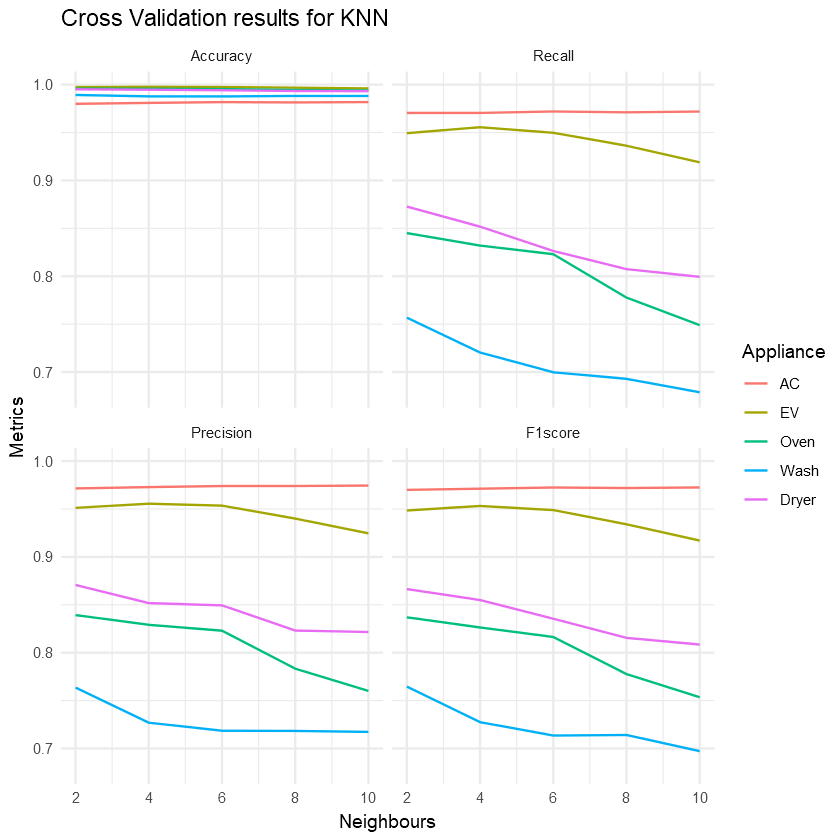

In [50]:
results_KNN <- rbind(AC_KNN, EV_KNN, oven_KNN, wash_KNN, dryer_KNN)
results_KNN.m <- melt(results_KNN, id=c("Model", "Appliance", "Neighbors"))
names(results_KNN.m) <- c("Model", "Appliance", "Neighbors", "Metrics", "Value")

ggplot(data=results_KNN.m, aes(x=Neighbors, y=as.numeric(Value), color=Appliance)) + 
    geom_line() + 
    facet_wrap(~Metrics) + 
    theme_minimal() +
    ggtitle("Cross Validation results for KNN ") +
    xlab("Neighbours") + ylab("Metrics")

### 6.2 Model 2: Logistic Regression <a class="anchor" id="sec_6.2"></a>
We fine tune Logistic Regression for each of the 5 appliance to get the best threshold for each of the appliance and get different metircs. In this we use the stratified cross validation function we made before.

### AC

In [92]:
# column indexes of important features
index.imp.features = match(imp.features.ac, colnames(train.dataset.ac))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [31]:
## Dataset to test
dataset <-  train.dataset.ac[, c(indexes, ncol(train.dataset.ac)) ]
thres <- length(seq(0.1, 0.9, 0.2))

metrics_LR <- data.frame('Model'= rep("LR", thres), 'Appliance'= rep("AC", thres), 'Threshold'=seq(0.1, 0.9, 0.2), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.1, 0.9, 0.2)){
    metrics <- cross_validation(dataset, folds=10, thres=thres, model='LogisticRegression')
    metrics_LR[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_LR[count, 'Recall'] <- mean(metrics$recall)
    metrics_LR[count, 'Precision'] <- mean(metrics$precision)
    metrics_LR[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_LR,"./AC_LR_results.csv", row.names = FALSE)
head(metrics_LR)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
LR,AC,0.1,0.9753002,0.9669865,0.9627743,0.9642777
LR,AC,0.3,0.9841002,0.9775960,0.9768045,0.9765408
LR,AC,0.5,0.9867502,0.9802944,0.9813638,0.9802498
LR,AC,0.7,0.9861501,0.9782871,0.9805627,0.9792269
LR,AC,0.9,0.9822503,0.9719973,0.9753591,0.9730489


#### EV

In [32]:
# column indexes of important features
index.imp.features = match(imp.features.ev, colnames(train.dataset.ev))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [33]:
## Dataset to test
dataset <-  train.dataset.ev[, c(indexes, ncol(train.dataset.ev))]
thres <- length(seq(0.1, 0.9, 0.2))

metrics_LR <- data.frame('Model'= rep("LR", thres), 'Appliance'= rep("EV", thres), 'Threshold'=seq(0.1, 0.9, 0.2), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.1, 0.9, 0.2)){
    metrics <- cross_validation(dataset, folds=10, thres=thres, model='LogisticRegression')
    metrics_LR[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_LR[count, 'Recall'] <- mean(metrics$recall)
    metrics_LR[count, 'Precision'] <- mean(metrics$precision)
    metrics_LR[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_LR,"./EV_LR_results.csv", row.names = FALSE)
head(metrics_LR)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
LR,EV,0.1,0.9834510,0.7437903,0.7271236,0.7265027
LR,EV,0.3,0.9927002,0.8518015,0.8571046,0.8494817
LR,EV,0.5,0.9937505,0.8577929,0.8729444,0.8602388
LR,EV,0.7,0.9926502,0.8212405,0.8420738,0.8262812
LR,EV,0.9,0.9887502,0.6919747,0.7241717,0.6965889


#### Oven

In [34]:
# column indexes of important features
index.imp.features = match(imp.features.oven, colnames(train.dataset.oven))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [36]:
## Dataset to test
dataset <- train.dataset.oven[, c(indexes, ncol(train.dataset.oven))]
thres <- length(seq(0.1, 0.9, 0.2))

metrics_LR <- data.frame('Model'= rep("LR", thres), 'Appliance'= rep("Oven", thres), 'Threshold'=seq(0.1, 0.9, 0.2), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.1, 0.9, 0.2)){
    metrics <- cross_validation(dataset, folds=10, thres=thres, model='LogisticRegression')
    metrics_LR[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_LR[count, 'Recall'] <- mean(metrics$recall)
    metrics_LR[count, 'Precision'] <- mean(metrics$precision)
    metrics_LR[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_LR,"./Oven_LR_results.csv", row.names = FALSE)
head(metrics_LR)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
LR,Oven,0.1,0.9872000,0.6848010,0.6547329,0.6643922
LR,Oven,0.3,0.9905004,0.6962285,0.6841284,0.6806662
LR,Oven,0.5,0.9920508,0.6765626,0.6876884,0.6738485
LR,Oven,0.7,0.9909506,0.5377379,0.5721295,0.5507710
LR,Oven,0.9,0.9895007,0.3493386,0.4008537,0.3509391


#### Wash

In [42]:
# column indexes of important features
index.imp.features = match(imp.features.wash, colnames(train.dataset.wash))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [55]:
## Dataset to test
dataset <- train.dataset.wash[, c(indexes, ncol(train.dataset.wash))]
thres <- length(seq(0.1, 0.9, 0.2))

metrics_LR <- data.frame('Model'= rep("LR", thres), 'Appliance'= rep("Wash", thres), 'Threshold'=seq(0.1, 0.9, 0.2), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.1, 0.9, 0.2)){
    metrics <- cross_validation(dataset, folds=10, thres=thres, model='LogisticRegression')
    metrics_LR[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_LR[count, 'Recall'] <- mean(metrics$recall)
    metrics_LR[count, 'Precision'] <- mean(metrics$precision)
    metrics_LR[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_LR,"./Wash_LR_results.csv", row.names = FALSE)
head(metrics_LR)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
LR,Wash,0.1,0.9101845,0.6100006,0.5662012,0.5757625
LR,Wash,0.3,0.9459946,0.7014719,0.6742411,0.6787620
LR,Wash,0.5,0.9614991,0.6987218,0.7003583,0.6947844
LR,Wash,0.7,0.9496779,0.5228998,0.5198695,0.5251898
LR,Wash,0.9,0.9270181,0.2463124,0.3086500,0.2495150


#### Dryer

In [56]:
# column indexes of important features
index.imp.features = match(imp.features.dryer, colnames(train.dataset.dryer))
# index of onehot encoding of hourofday and dayofweek
index.onehot = seq(1,31)

# hourofday + dayofweek + important selected features 
indexes = c(index.onehot, index.imp.features)

In [58]:
## Dataset to test
dataset <- train.dataset.dryer[, c(indexes, ncol(train.dataset.dryer)) ]
thres <- length(seq(0.1, 0.9, 0.2))

metrics_LR <- data.frame('Model'= rep("LR", thres), 'Appliance'= rep("Dryer", thres), 'Threshold'=seq(0.1, 0.9, 0.2), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.1, 0.9, 0.2)){
    metrics <- cross_validation(dataset, folds=10, thres=thres, model='LogisticRegression')
    metrics_LR[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_LR[count, 'Recall'] <- mean(metrics$recall)
    metrics_LR[count, 'Precision'] <- mean(metrics$precision)
    metrics_LR[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_LR,"./Dryer_LR_results.csv", row.names = FALSE)
head(metrics_LR)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
LR,Dryer,0.1,0.9620090,0.6597579,0.6239715,0.6371623
LR,Dryer,0.3,0.9814038,0.7781518,0.7698934,0.7673955
LR,Dryer,0.5,0.9815028,0.7263683,0.7350821,0.7247194
LR,Dryer,0.7,0.9783034,0.5902721,0.6140816,0.5921564
LR,Dryer,0.9,0.9725031,0.3666282,0.4232988,0.3747196


### Comparison of Logistic Regression Models

In [51]:
AC_LR <- read.csv("./AC_LR_results.csv")
EV_LR <- read.csv("./EV_LR_results.csv")
oven_LR <- read.csv("./Oven_LR_results.csv")
wash_LR <- read.csv("./Wash_LR_results.csv")
dryer_LR <- read.csv("./Dryer_LR_results.csv")

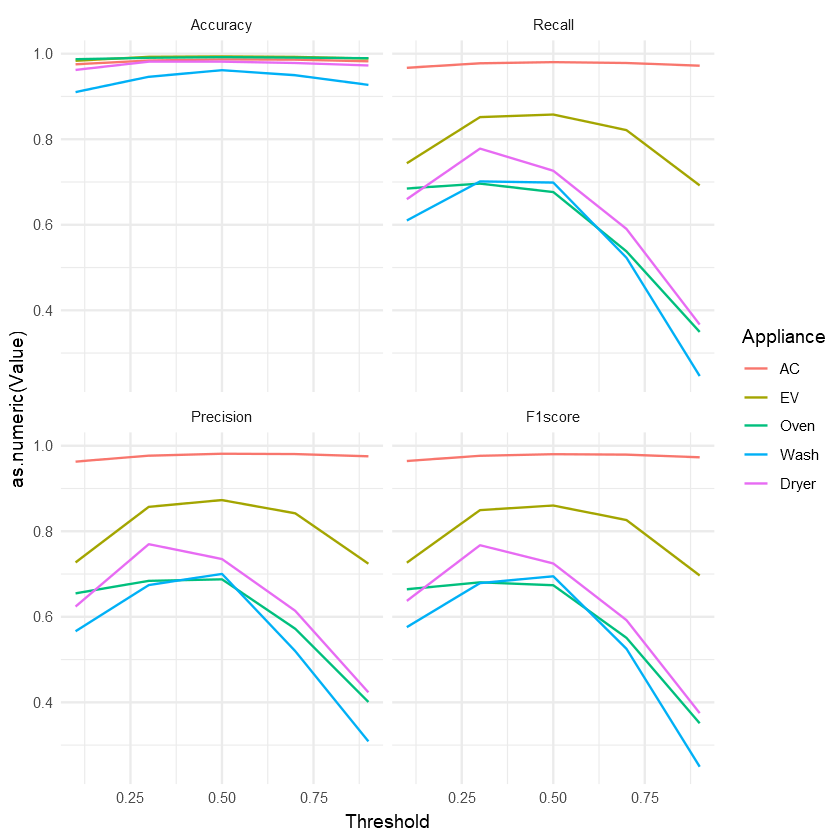

In [52]:
results_LR <- rbind(AC_LR, EV_LR, oven_LR, wash_LR, dryer_LR)
results_LR.m <- melt(results_LR, id=c("Model", "Appliance", "Threshold"))
names(results_LR.m) <- c("Model", "Appliance", "Threshold", "Metrics", "Value")
ggplot(data=results_LR.m, aes(x=Threshold, y=as.numeric(Value), color=Appliance)) + geom_line() + facet_wrap(~Metrics) + 
theme_minimal()

### 6.3 Model 3: Gradient Boosting  <a class="anchor" id="sec_6.3"></a>

#### Get the data to build the model

In [9]:
# make 5 different datasets for each of the appliance
train.ac.xgb = get_train_dataset(train.dataset, 'ac')
train.ev.xgb = get_train_dataset(train.dataset, 'ev')
train.oven.xgb = get_train_dataset(train.dataset, 'oven')
train.wash.xgb = get_train_dataset(train.dataset, 'wash')
train.dryer.xgb = get_train_dataset(train.dataset, 'dryer')

Note: Using an external vector in selections is ambiguous.
i Use `all_of(appliance)` instead of `appliance` to silence this message.
i See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


#### Split to Train and Validation for XG Boost

In [10]:
## split to train(70%) and validation(30%)
stratas.ac <- partition(train.ac.xgb$ac, p = c(train.ac= 0.7,test.ac = 0.3), set.seed(1))
stratas.ev <- partition(train.ev.xgb$ev, p = c(train.ev = 0.7,test.ev = 0.3), set.seed(1))
stratas.oven <- partition(train.oven.xgb$oven, p = c(train.oven = 0.7,test.oven = 0.3), set.seed(1))
stratas.wash <- partition(train.wash.xgb$wash, p = c(train.wash = 0.7,test.wash = 0.3), set.seed(2))
stratas.dryer <- partition(train.dryer.xgb$dryer, p = c(train.dryer = 0.7,test.dryer = 0.3), set.seed(1))

train.ac <- train.ac.xgb[stratas.ac$train.ac, ]
test.ac <- train.ac.xgb[stratas.ac$test.ac, ]

train.ev <- train.ev.xgb[stratas.ev $train.ev , ]
test.ev <- train.ev.xgb[stratas.ev $test.ev , ]

train.oven <- train.oven.xgb[stratas.oven$train.oven, ]
test.oven <- train.oven.xgb[stratas.oven$test.oven, ]

train.wash <- train.wash.xgb[stratas.wash$train.wash, ]
test.wash <- train.wash.xgb[stratas.wash$test.wash, ]

train.dryer <- train.dryer.xgb[stratas.dryer$train.dryer, ]
test.dryer <- train.dryer.xgb[stratas.dryer$test.dryer, ]

#### Calculate Scale Pos Weight for XGBoost
Since this dataset is imbalanced, we utilized the “scale_pos_weight” parameter in XGBoost algorithm which takes care of the imbalanced datasets and the value depends on the ratio of the number of zeros to the number ones for each appliance.

In [31]:
cat('AC Scale Pos Weight:', nrow(train.ac.xgb[train.ac.xgb$ac==0,])/nrow(train.ac.xgb[train.ac.xgb$ac==1,]),'\n')
cat('EV Scale Pos Weight:',nrow(train.ev.xgb[train.ev.xgb$ev==0,])/nrow(train.ev.xgb[train.ev.xgb$ev==1,]), '\n')
cat('Oven Scale Pos Weight:',nrow(train.oven.xgb[train.oven.xgb$oven==0,])/nrow(train.oven.xgb[train.oven.xgb$oven==1,]), '\n')
cat('Wash Scale Pos Weight:',nrow(train.wash.xgb[train.wash.xgb$wash==0,])/nrow(train.wash.xgb[train.wash.xgb$wash==1,]), '\n')
cat('Dryer Scale Pos Weight:',nrow(train.dryer.xgb[train.dryer.xgb$dryer==0,])/nrow(train.dryer.xgb[train.dryer.xgb$dryer==1,]), '\n')

AC Scale Pos Weight: 3.127709 
EV Scale Pos Weight: 177.8951 
Oven Scale Pos Weight: 69.13432 
Wash Scale Pos Weight: 51.52358 
Dryer Scale Pos Weight: 29.769 


#### Helper functions for XG Boost

In [106]:
head(test.ac)

,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst,load,ac
5,0,Sun,0.002,0.002,6.215,3.302744,0.6212951,0.08263997,0.9940406,2.270,0
8,0,Sun,0.001,0.001,6.215,3.238982,0.6519165,0.35420293,0.9927028,2.251,0
10,0,Sun,0.013,0.013,6.215,3.196127,0.6500062,0.36657811,0.9923085,2.277,0
15,0,Sun,0.008,0.008,6.215,3.119437,0.6459650,0.20307140,0.9932828,2.449,0
28,0,Sun,-0.008,0.008,6.215,3.210240,0.6082089,0.30235609,0.9936660,6.207,1
29,0,Sun,-0.008,0.008,6.215,3.208092,0.6153455,0.30160249,0.9936364,6.199,1


In [21]:
## makes xgb matrix for train and test data
prepare_data_xgboost <- function(train.df, test.df){
    # defining seed to get the same result in each run
    set.seed(1) 
    
    # Transformation of training dataset
     # square up the numerical values
    df.sq <- (train.df[,which(sapply(train.df,is.numeric))]^2)
    df.factor <- train.df[,which(sapply(train.df,is.factor))]
    
    train.df = data.matrix(cbind(df.factor, df.sq))
    
    # Transformation of training dataset
     # square up the numerical values
    df.sq <- (test.df[,which(sapply(test.df,is.numeric))]^2)
    df.factor <- test.df[,which(sapply(test.df,is.factor))]
    
    test.df = data.matrix(cbind(df.factor, df.sq))

    # converting the training dataset to matrix with hot encoding of categorical variables
    x_training <- data.matrix(train.df[,-c(ncol(train.df))])
    # target variable
    y_training <- train.df[,ncol(train.df)]
    
    # convert the training dataset to xgb matrix
    training_xgb = xgb.DMatrix(data = x_training,
                               label = y_training)
    
    # converting the testing dataset to matrix with hot encoding of categorical variables
    x_testing = data.matrix(test.df[,-c(ncol(test.df))])

    # convert the testing dataset to xgb matrix
    testing_xgb = xgb.DMatrix(data = x_testing)
    
    y_testing <- test.df[,ncol(test.df)]
    
    return(list('train.xbg' = training_xgb, 'test.xbg' = testing_xgb, 'y_testing' = y_testing ))
}

In [23]:
# Performs the CV and finds the best nround posible, with thet nround trains the model
get_xgboost_cv_model <- function(training_xgb, scale){

    # defining the parameters
    parameter_list = list(objective = "binary:logistic")

    # finding the best n_rounds
    xgboost_cv <- xgb.cv(params = parameter_list, 
                            data = training_xgb, 
                            nrounds = 1000, 
                            nfold = 5,
                            early_stopping_rounds = 30, 
                            maximize = F, 
                            scale_pos_weight = scale) # Parameter for unbalanced data
    
    # defining the maximum number of iteration
    n_round = xgboost_cv$best_iteration
    
    # defining the parameters
    parameter_list = list(objective = "binary:logistic")
    
    # training the model
    xgb_model = xgb.train(data = training_xgb, 
                          params = parameter_list, 
                          nrounds = n_round)
    return(xgb_model)
}

In [13]:
# Returns the metrics of the prediction 
get_metrics_xgb <- function(xgb_model, testing_xgb, y_testing, threshold = 0.5 ){
    
    predict.label_ac<- ifelse(predict(xgb_model, 
                              newdata = testing_xgb) > threshold,1,0)

    accuracy <- Accuracy(y_testing ,predict.label_ac)
    f1score <- F1_Score(y_testing, predict.label_ac, positive = 1)
    precision <- Precision(y_testing, predict.label_ac, positive = 1)
    recall <- Recall(y_testing, predict.label_ac, positive = 1)
    
    # return list of metrics
    # use it to plot the accuracy plot
    return(list(accuracy=accuracy,f1score=f1score,recall=recall,precision=precision))
    
}

## AC

In [24]:
## Dataset to test
data.ac.xg = prepare_data_xgboost(train.ac, test.ac)
xgboost_cv_ac = get_xgboost_cv_model(data.ac.xg$train.xbg,  3.127709)

[20:17:32] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:32] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:33] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:33] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

In [32]:
thres <- length(seq(0.05, 0.95, 0.05))
metrics_XGB <- data.frame('Model'= rep("XGB", thres), 'Appliance'= rep("AC", thres), 'Threshold'=rep(0, thres), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.05, 0.95, 0.05)){
    metrics <- get_metrics_xgb(xgboost_cv_ac, data.ac.xg$test.xbg, data.ac.xg$y_testing, thres)
    metrics_XGB[count, 'Threshold'] <- thres
    metrics_XGB[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_XGB[count, 'Recall'] <- mean(metrics$recall)
    metrics_XGB[count, 'Precision'] <- mean(metrics$precision)
    metrics_XGB[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_XGB,"./AC_XGB_results.csv", row.names = FALSE)
head(metrics_XGB)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
XGB,AC,0.05,0.9848305,0.9964427,0.9440474,0.9695377
XGB,AC,0.10,0.9889400,0.9942358,0.9614282,0.9775568
XGB,AC,0.15,0.9907993,0.9925560,0.9701555,0.9812279
XGB,AC,0.20,0.9920362,0.9911067,0.9763774,0.9836869
XGB,AC,0.25,0.9927464,0.9898880,0.9803621,0.9851020
XGB,AC,0.30,0.9931613,0.9890316,0.9828484,0.9859303


### EV

In [33]:
## Dataset to test
data.ev.xg = prepare_data_xgboost(train.ev, test.ev)
xgboost_cv_ev = get_xgboost_cv_model(data.ev.xg$train.xbg, 177.8951)

[20:29:26] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:27] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:27] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:28] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

In [34]:
thres <- length(seq(0.05, 0.95, 0.05))
metrics_XGB <- data.frame('Model'= rep("XGB", thres), 'Appliance'= rep("EV", thres), 'Threshold'=rep(0, thres), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.05, 0.95, 0.05)){
    metrics <- get_metrics_xgb(xgboost_cv_ev, data.ev.xg$test.xbg, data.ev.xg$y_testing, thres)
    metrics_XGB[count, 'Threshold'] <- thres
    metrics_XGB[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_XGB[count, 'Recall'] <- mean(metrics$recall)
    metrics_XGB[count, 'Precision'] <- mean(metrics$precision)
    metrics_XGB[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_XGB,"./EV_XGB_results.csv", row.names = FALSE)
head(metrics_XGB)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
XGB,EV,0.05,0.9997446,0.9814551,0.9731259,0.9772727
XGB,EV,0.10,0.9998005,0.9800285,0.9842407,0.9821301
XGB,EV,0.15,0.9997845,0.9728959,0.9884058,0.9805895
XGB,EV,0.20,0.9997686,0.9700428,0.9883721,0.9791217
XGB,EV,0.25,0.9997287,0.9629101,0.9882870,0.9754335
XGB,EV,0.30,0.9997606,0.9629101,0.9941090,0.9782609


#### Oven

In [35]:
## Dataset to test
data.oven.xg = prepare_data_xgboost(train.oven, test.oven)
xgboost_cv_oven = get_xgboost_cv_model(data.oven.xg$train.xbg, 69.13432)

[20:35:26] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:26] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:26] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:27] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

In [36]:
thres <- length(seq(0.05, 0.95, 0.05))

metrics_XGB <- data.frame('Model'= rep("XGB", thres), 'Appliance'= rep("Oven", thres), 'Threshold'=rep(0, thres), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.05, 0.95, 0.05)){
    metrics <- get_metrics_xgb(xgboost_cv_oven, data.oven.xg$test.xbg, data.oven.xg$y_testing, thres)
    metrics_XGB[count, 'Threshold'] <- thres
    metrics_XGB[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_XGB[count, 'Recall'] <- mean(metrics$recall)
    metrics_XGB[count, 'Precision'] <- mean(metrics$precision)
    metrics_XGB[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_XGB,"./Oven_XGB_results.csv", row.names = FALSE)
head(metrics_XGB)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
XGB,Oven,0.05,0.9958346,0.9686626,0.7878926,0.8689759
XGB,Oven,0.10,0.9969358,0.9580302,0.8471054,0.8991597
XGB,Oven,0.15,0.9971991,0.9468383,0.8685832,0.9060241
XGB,Oven,0.20,0.9973826,0.9390039,0.8845546,0.9109663
XGB,Oven,0.25,0.9974784,0.9311696,0.8960689,0.9132821
XGB,Oven,0.30,0.9975901,0.9278120,0.9055161,0.9165285


#### Wash

In [37]:
## Dataset to test
data.wash.xg = prepare_data_xgboost(train.wash, test.wash)
xgboost_cv_wash = get_xgboost_cv_model(data.wash.xg$train.xbg, 51.52358)

[20:44:28] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:44:28] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:44:28] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:44:29] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

In [38]:
thres <- length(seq(0.05, 0.95, 0.05))

metrics_XGB <- data.frame('Model'= rep("XGB", thres), 'Appliance'= rep("Wash", thres), 'Threshold'=rep(0, thres), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.05, 0.95, 0.05)){
    metrics <- get_metrics_xgb(xgboost_cv_wash, data.wash.xg$test.xbg, data.wash.xg$y_testing, thres)
    metrics_XGB[count, 'Threshold'] <- thres
    metrics_XGB[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_XGB[count, 'Recall'] <- mean(metrics$recall)
    metrics_XGB[count, 'Precision'] <- mean(metrics$precision)
    metrics_XGB[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_XGB,"./Wash_XGB_results.csv", row.names = FALSE)
head(metrics_XGB)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
XGB,Wash,0.05,0.9879107,0.8914501,0.6287319,0.7373895
XGB,Wash,0.10,0.9906796,0.8499581,0.7145877,0.7764165
XGB,Wash,0.15,0.9915335,0.8118189,0.7599058,0.7850051
XGB,Wash,0.20,0.9919883,0.7829003,0.7935429,0.7881857
XGB,Wash,0.25,0.9919005,0.7497904,0.8106026,0.7790115
XGB,Wash,0.30,0.9916292,0.7166806,0.8209313,0.7652719


#### Dryer

In [43]:
## Dataset to test
data.dryer.xg = prepare_data_xgboost(train.dryer, test.dryer)
xgboost_cv_dryer = get_xgboost_cv_model(data.dryer.xg$train.xbg, 29.769)

[21:27:46] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:46] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:47] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:27:47] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

In [44]:
thres <- length(seq(0.05, 0.95, 0.05))

metrics_XGB <- data.frame('Model'= rep("XGB", thres), 'Appliance'= rep("Dryer", thres), 'Threshold'=rep(0, thres), 
                          'Accuracy'=rep(0, thres), 'Recall'=rep(0, thres), 
                          'Precision'=rep(0, thres), 'F1score'=rep(0, thres))

count <- 1
for (thres in seq(0.05, 0.95, 0.05)){
    metrics <- get_metrics_xgb(xgboost_cv_dryer, data.dryer.xg$test.xbg, data.dryer.xg$y_testing, thres)
    metrics_XGB[count, 'Threshold'] <- thres
    metrics_XGB[count, 'Accuracy'] <- mean(metrics$accuracy)
    metrics_XGB[count, 'Recall'] <- mean(metrics$recall)
    metrics_XGB[count, 'Precision'] <- mean(metrics$precision)
    metrics_XGB[count, 'F1score'] <- mean(metrics$f1score)
    count <- count + 1
}
write.csv(metrics_XGB,"./Dryer_XGB_results.csv", row.names = FALSE)
head(metrics_XGB)

Model,Appliance,Threshold,Accuracy,Recall,Precision,F1score
XGB,Dryer,0.05,0.9952361,0.9869875,0.8808063,0.9308788
XGB,Dryer,0.10,0.9968799,0.9796219,0.9283388,0.9532911
XGB,Dryer,0.15,0.9974465,0.9702922,0.9520597,0.9610895
XGB,Dryer,0.20,0.9975981,0.9653818,0.9608993,0.9631353
XGB,Dryer,0.25,0.9976619,0.9612080,0.9666667,0.9639296
XGB,Dryer,0.30,0.9977098,0.9562976,0.9727772,0.9644670


In [45]:
AC_XGB <- read.csv("./AC_XGB_results.csv")
EV_XGB <- read.csv("./EV_XGB_results.csv")
oven_XGB <- read.csv("./Oven_XGB_results.csv")
wash_XGB <- read.csv("./Wash_XGB_results.csv")
dryer_XGB <- read.csv("./Dryer_XGB_results.csv")

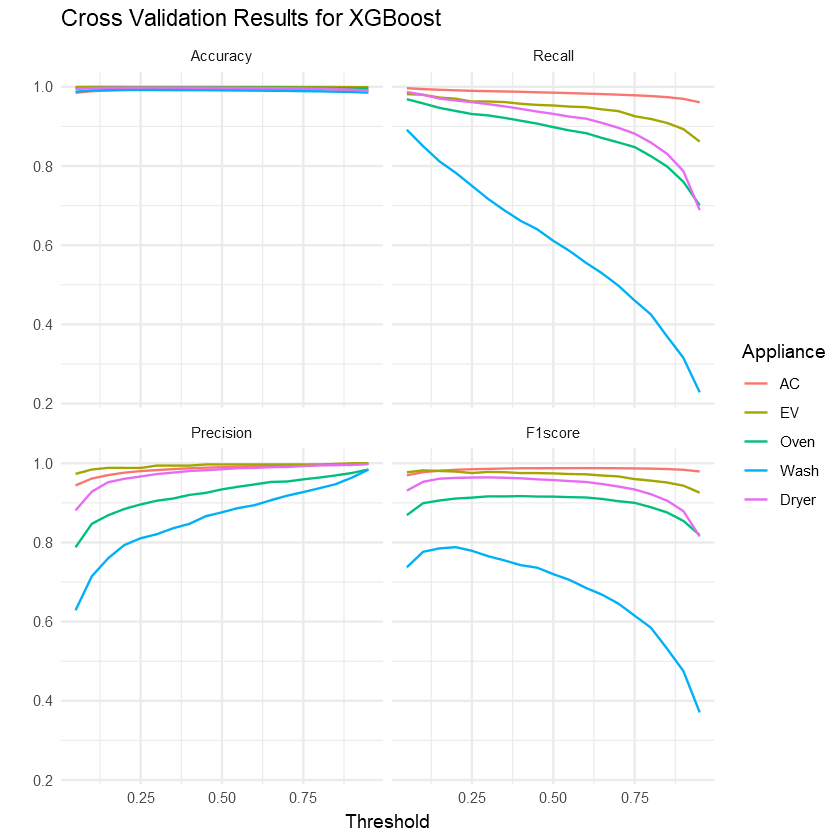

In [47]:
results_XGB <- rbind(AC_XGB, EV_XGB, oven_XGB, wash_XGB, dryer_XGB)
results_XGB.m <- melt(results_XGB, id=c("Model", "Appliance", "Threshold"))
names(results_XGB.m) <- c("Model", "Appliance", "Threshold", "Metrics", "Value")
ggplot(data=results_XGB.m, aes(x=Threshold, y=as.numeric(Value), color=Appliance)) + geom_line() + facet_wrap(~Metrics) +
theme_minimal() + ylab(" ") + ggtitle("Cross Validation Results for XGBoost")

## 7. Conclusion  <a class="anchor" id="sec_7"></a>

In [53]:
names(results_KNN.m) <- c("Model", "Appliance", "Hyperparameter", "Metrics", "Value")
names(results_LR.m) <- c("Model", "Appliance", "Hyperparameter", "Metrics", "Value")
names(results_XGB.m) <- c("Model", "Appliance", "Hyperparameter", "Metrics", "Value")
results=rbind(results_KNN.m, results_LR.m, results_XGB.m)

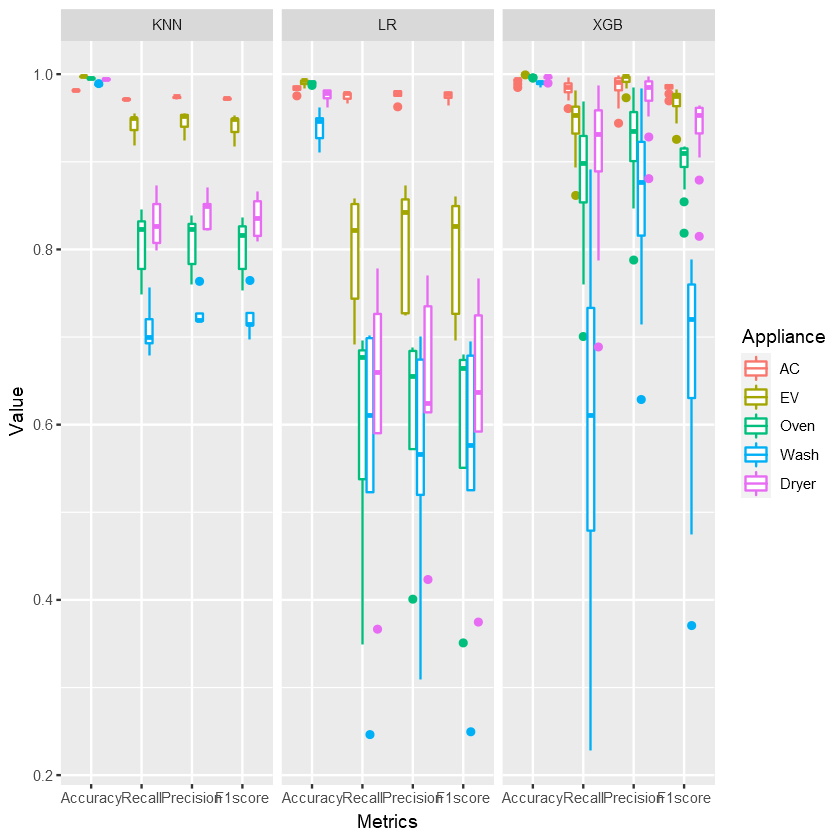

In [54]:
ggplot(data=results,aes(x=Metrics, y=Value, color=Appliance)) + geom_boxplot() + facet_wrap(~Model)

### F1 Score

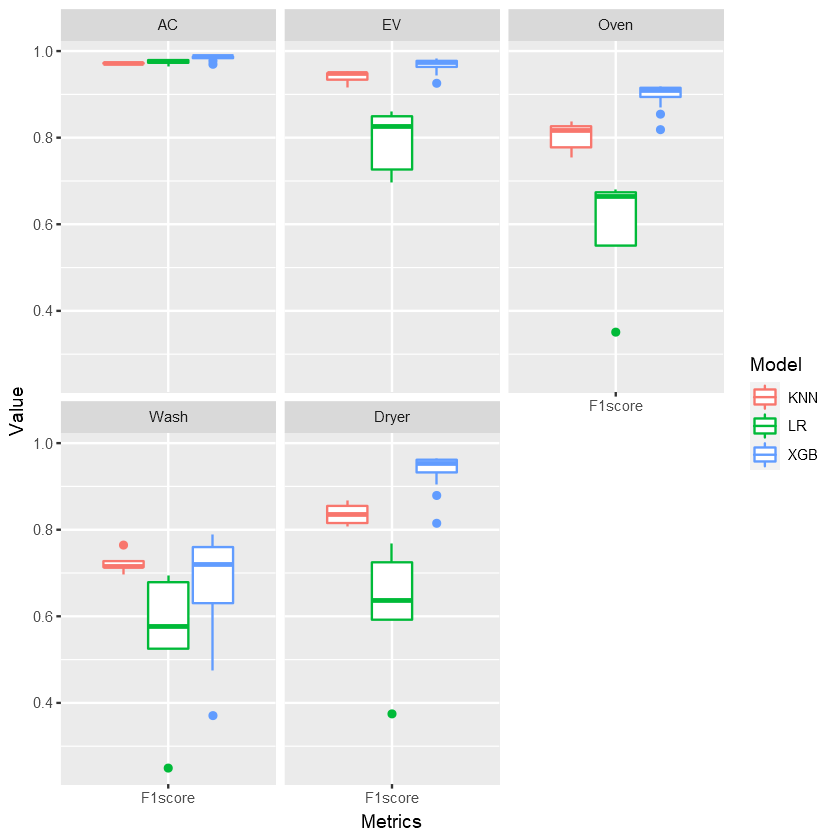

In [55]:
ggplot(data=results[results$Metrics == "F1score",],aes(x=Metrics, y=Value, color=Model)) + geom_boxplot() + facet_wrap(~Appliance)

### Recall

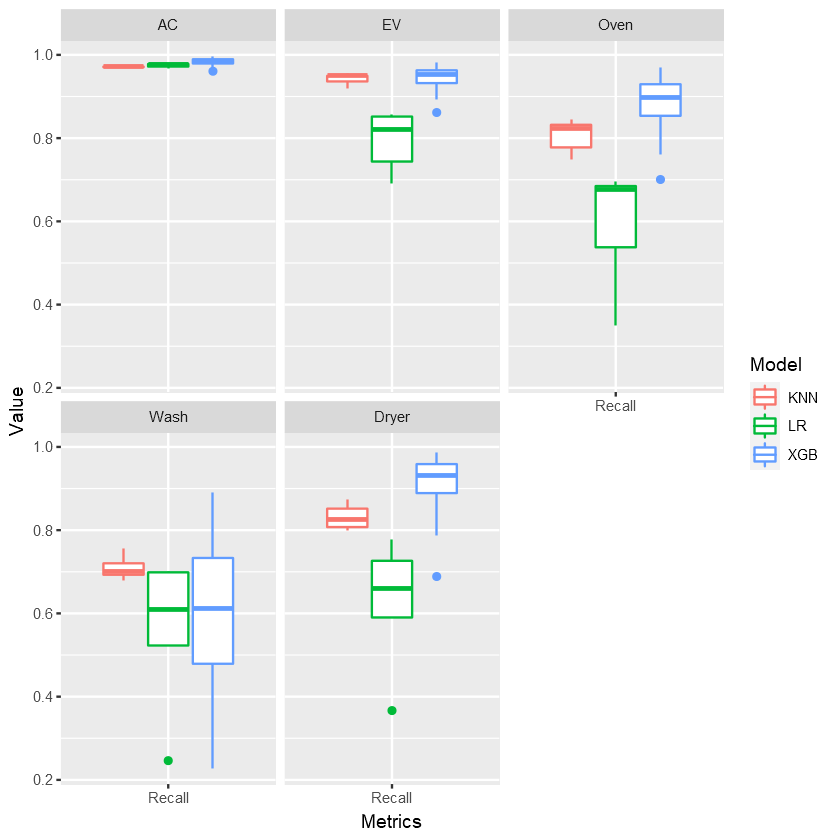

In [56]:
ggplot(data=results[results$Metrics == "Recall",],aes(x=Metrics, y=Value, color=Model)) + geom_boxplot() + facet_wrap(~Appliance)

### Accuracy

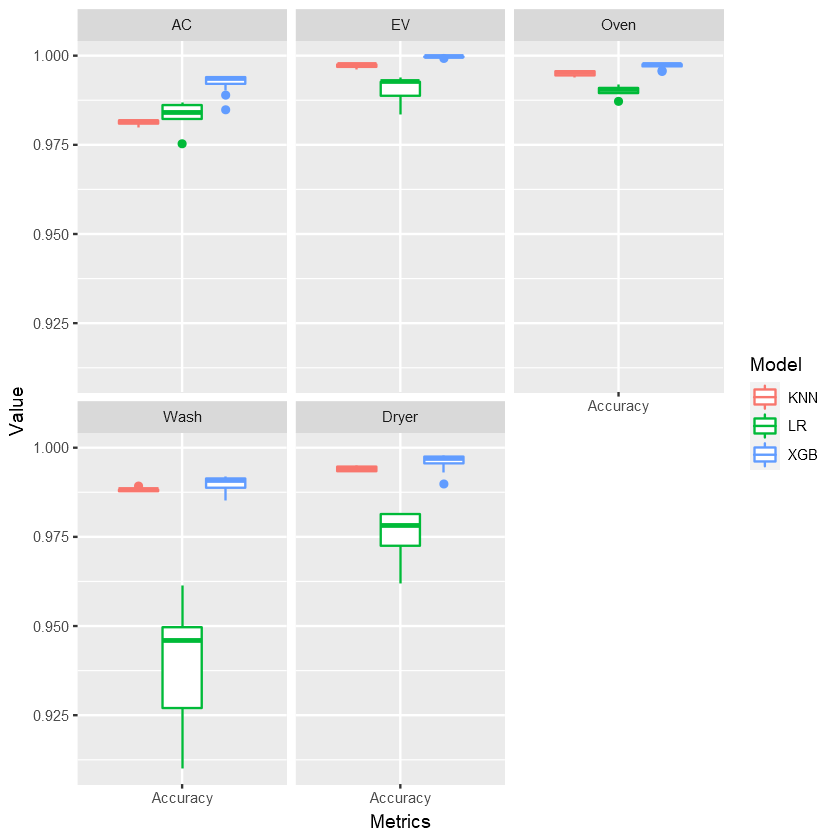

In [57]:
ggplot(data=results[results$Metrics == "Accuracy",],aes(x=Metrics, y=Value, color=Model)) + geom_boxplot() + facet_wrap(~Appliance)

### Precision

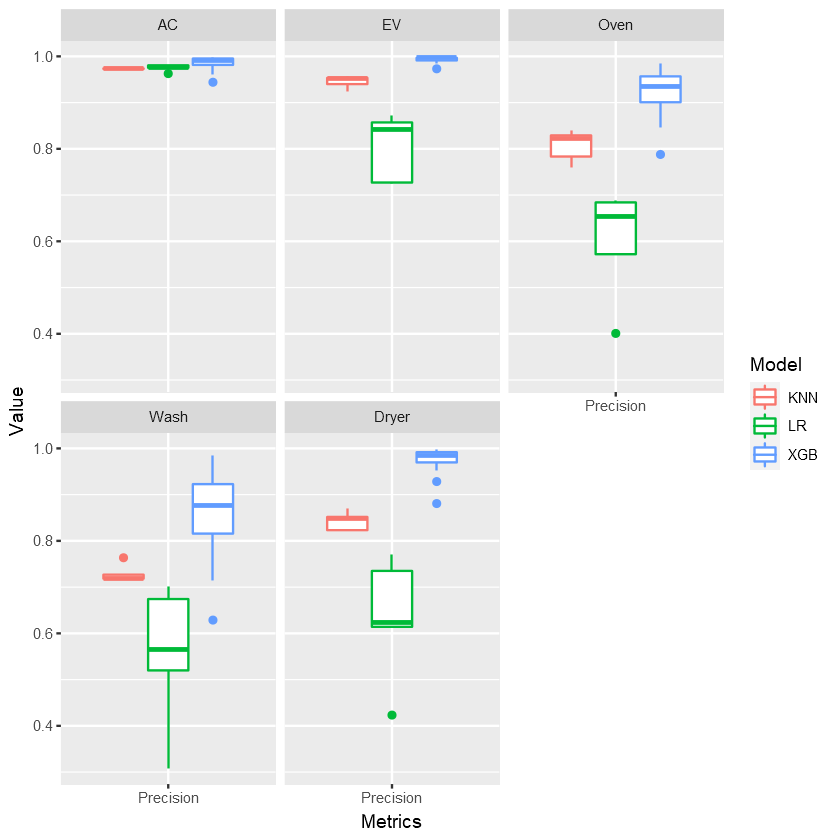

In [58]:
ggplot(data=results[results$Metrics == "Precision",],aes(x=Metrics, y=Value, color=Model)) + geom_boxplot() + facet_wrap(~Appliance)

## 7.1 Best Models  <a class="anchor" id="sec_7.1"></a>

In [59]:
## makes xgb matrix for train and test data
prepare_data_to_submit <- function(train.df, test.df=NULL){
    # defining seed to get the same result in each run
    set.seed(1) 
    
    # Transformation of training dataset
     # square up the numerical values
    df.sq <- (train.df[,which(sapply(train.df,is.numeric))]^2)
    df.factor <- train.df[,which(sapply(train.df,is.factor))]
    
    train.df = data.matrix(cbind(df.factor, df.sq))

    # converting the training dataset to matrix with hot encoding of categorical variables
    x_training <- data.matrix(train.df[,-c(ncol(train.df))])
    # target variable
    y_training <- train.df[,ncol(train.df)]
    
    # convert the training dataset to xgb matrix
    training_xgb = xgb.DMatrix(data = x_training,
                               label = y_training)
    if (length(test.df) != 0){
        
        # Transformation of training dataset
        # square up the numerical values
        df.sq <- (test.df[,which(sapply(test.df,is.numeric))]^2)
        df.factor <- test.df[,which(sapply(test.df,is.factor))]

        test.df = data.matrix(cbind(df.factor, df.sq))
        
        # converting the testing dataset to matrix with hot encoding of categorical variables
        x_testing = data.matrix(test.df[,-c(ncol(test.df))])

        # convert the testing dataset to xgb matrix
        testing_xgb = xgb.DMatrix(data = x_testing)

        y_testing <- test.df[,ncol(test.df)]
        colnames(testing_xgb) <- NULL
    }
    else{
        y_testing <- NULL
        testing_xgb <- NULL
    }
    
    return(list('train.xbg' = training_xgb, 'test.xbg' = testing_xgb, 'y_testing' = y_testing ))
}

### AC

In [60]:
KNN_AC_F1 <- results[results$Appliance == 'AC' & results$Model == 'KNN' & results$Metrics == 'F1score',]
KNN <- KNN_AC_F1[KNN_AC_F1$Value == max(KNN_AC_F1$Value),]
XGB_AC_F1 <- results[results$Appliance == 'AC' & results$Model == 'XGB' & results$Metrics == 'F1score',]
XGB <- XGB_AC_F1[XGB_AC_F1$Value == max(XGB_AC_F1$Value),]
rbind(KNN, XGB)

,Model,Appliance,Hyperparameter,Metrics,Value
80,KNN,AC,10.00,F1score,0.9725435
496,XGB,AC,0.55,F1score,0.9878008


In [96]:
## Dataset to test
data.ac.xgb <- prepare_data_to_submit(train.ac.xgb, test.dataset)
ac = ifelse (predict(xgboost_cv_ac, data.ac.xgb$test.xbg) > 1/2028,1,0)

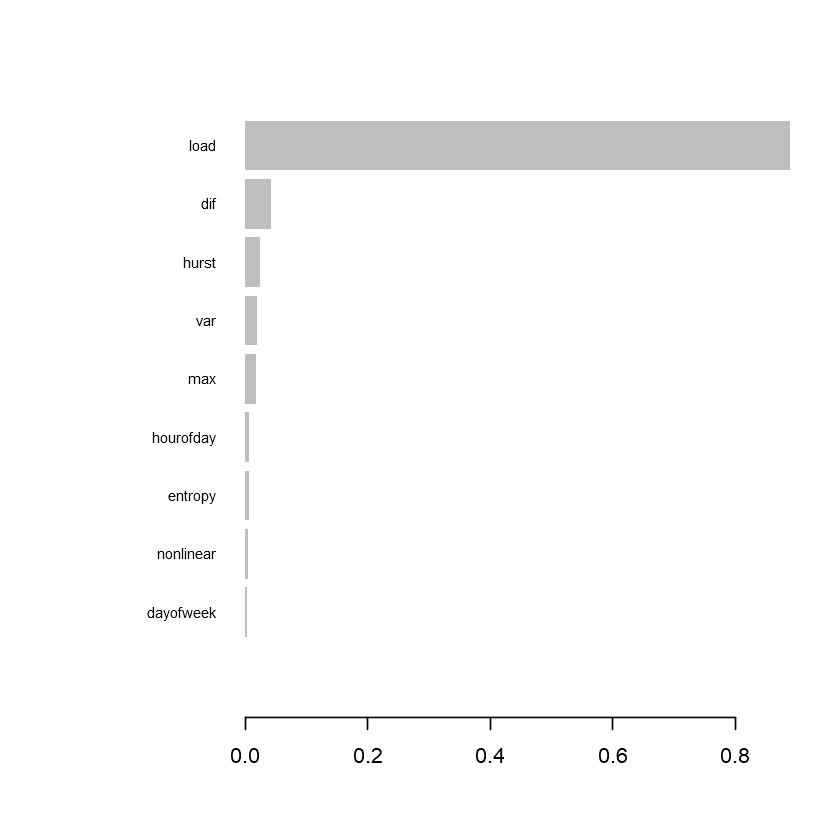

In [71]:
#view variable importance plot
mat <- xgb.importance (feature_names = colnames(train.ac.xgb),model = xgboost_cv_ac)
xgb.plot.importance (importance_matrix = mat[1:10])

### EV

In [73]:
KNN_EV_F1 <- results[results$Appliance == 'EV' & results$Model == 'KNN' & results$Metrics == 'F1score',]
KNN <- KNN_EV_F1[KNN_EV_F1$Value == max(KNN_EV_F1$Value),]
XGB_EV_F1 <- results[results$Appliance == 'EV' & results$Model == 'XGB' & results$Metrics == 'F1score',]
XGB <- XGB_EV_F1[XGB_EV_F1$Value == max(XGB_EV_F1$Value),]
rbind(KNN, XGB)

,Model,Appliance,Hyperparameter,Metrics,Value
82,KNN,EV,4.0,F1score,0.9532130
506,XGB,EV,0.1,F1score,0.9821301


In [97]:
## Dataset to test
data.ev.xgb <- prepare_data_to_submit(train.ev.xgb, test.dataset)
ev = ifelse (predict(xgboost_cv_ev, data.ev.xgb$test.xbg) >  1/2028,1,0)

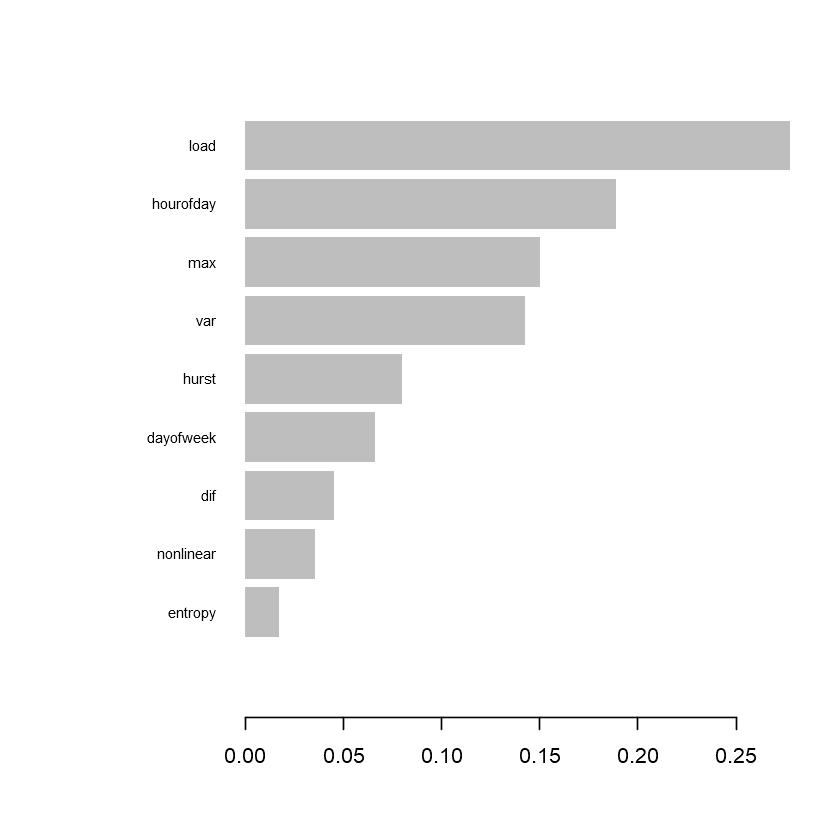

In [76]:
#view variable importance plot
mat <- xgb.importance (feature_names = colnames(train.ev.xgb),model = xgboost_cv_ev)
xgb.plot.importance (importance_matrix = mat[1:10])

### Oven

In [77]:
KNN_Oven_F1 <- results[results$Appliance == 'Oven' & results$Model == 'KNN' & results$Metrics == 'F1score',]
KNN <- KNN_Oven_F1[KNN_Oven_F1$Value == max(KNN_Oven_F1$Value),]
XGB_Oven_F1 <- results[results$Appliance == 'Oven' & results$Model == 'XGB' & results$Metrics == 'F1score',]
XGB <- XGB_Oven_F1[XGB_Oven_F1$Value == max(XGB_Oven_F1$Value),]
rbind(KNN, XGB)

,Model,Appliance,Hyperparameter,Metrics,Value
86,KNN,Oven,2.0,F1score,0.8369528
531,XGB,Oven,0.4,F1score,0.9172046


In [98]:
## Dataset to test
data.oven.xgb <- prepare_data_to_submit(train.oven.xgb, test.dataset)
oven = ifelse (predict(xgboost_cv_oven, data.oven.xgb$test.xbg) >  1/2028,1,0)

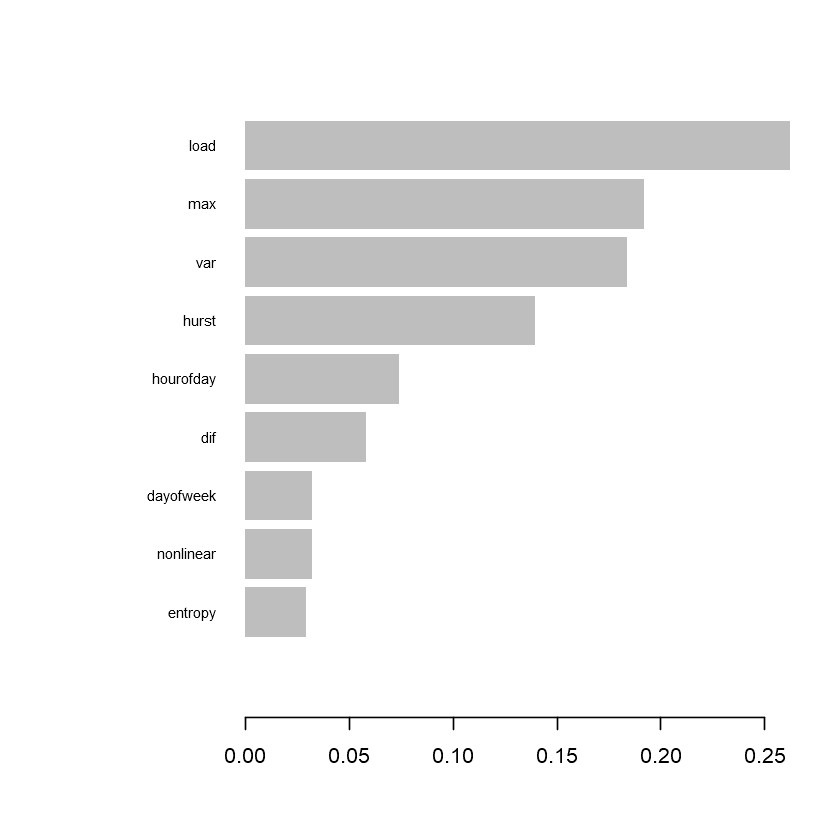

In [79]:
#view variable importance plot
mat <- xgb.importance (feature_names = colnames(train.oven.xgb),model = xgboost_cv_oven)
xgb.plot.importance (importance_matrix = mat[1:10])

In [ ]:
shap_values <- shap.prep(xgb_model = xgb_model_oven, X_train = data.oven.xgb$train.xbg)
shap.plot.summary(shap_values, scientific = TRUE)

### Wash

In [80]:
KNN_Wash_F1 <- results[results$Appliance == 'Wash' & results$Model == 'KNN' & results$Metrics == 'F1score',]
KNN <- KNN_Wash_F1[KNN_Wash_F1$Value == max(KNN_Wash_F1$Value),]
XGB_Wash_F1 <- results[results$Appliance == 'Wash' & results$Model == 'XGB' & results$Metrics == 'F1score',]
XGB <- XGB_Wash_F1[XGB_Wash_F1$Value == max(XGB_Wash_F1$Value),]
rbind(KNN, XGB)

,Model,Appliance,Hyperparameter,Metrics,Value
91,KNN,Wash,2.0,F1score,0.7645745
546,XGB,Wash,0.2,F1score,0.7881857


In [99]:
## Dataset to test
data.wash.xgb <- prepare_data_to_submit(train.wash.xgb, test.dataset)
wash = ifelse (predict(xgboost_cv_wash, data.wash.xgb$test.xbg) >  1/2028,1,0)

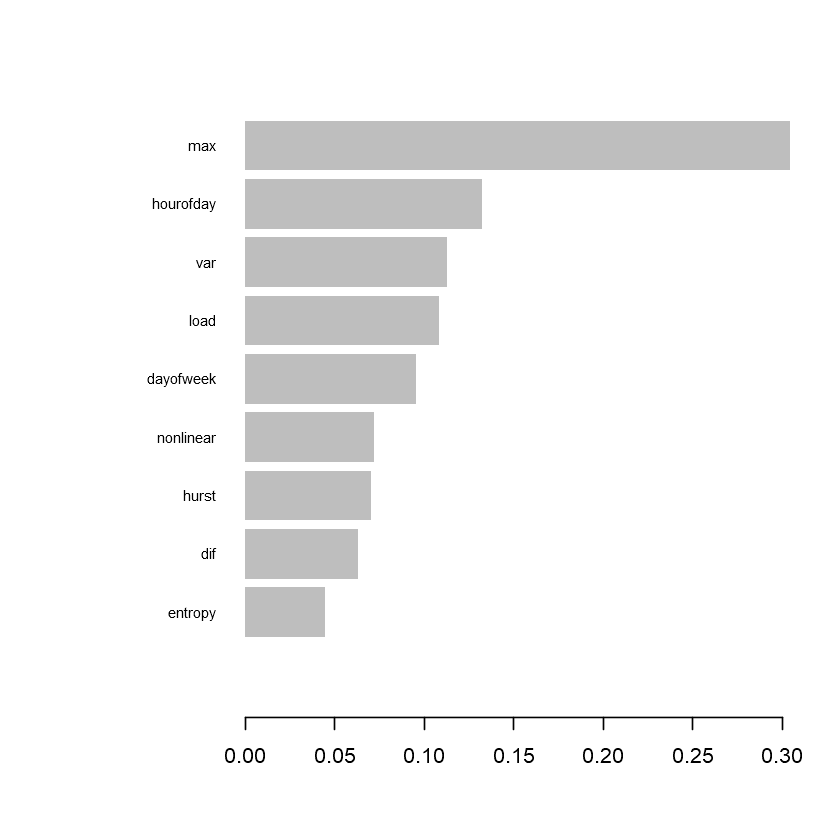

In [83]:
#view variable importance plot
mat <- xgb.importance (feature_names = colnames(train.wash.xgb),model = xgboost_cv_wash)
xgb.plot.importance (importance_matrix = mat[1:10])

In [ ]:
shap_values <- shap.prep(xgb_model = xgb_model_wash, X_train = data.wash.xgb$train.xbg)
shap.plot.summary(shap_values, scientific = TRUE)

### Dryer

In [84]:
KNN_Dryer_F1 <- results[results$Appliance == 'Dryer' & results$Model == 'KNN' & results$Metrics == 'F1score',]
KNN <- KNN_Dryer_F1[KNN_Dryer_F1$Value == max(KNN_Dryer_F1$Value),]
XGB_Dryer_F1 <- results[results$Appliance == 'Dryer' & results$Model == 'XGB' & results$Metrics == 'F1score',]
XGB <- XGB_Dryer_F1[XGB_Dryer_F1$Value == max(XGB_Dryer_F1$Value),]
rbind(KNN, XGB)

,Model,Appliance,Hyperparameter,Metrics,Value
96,KNN,Dryer,2.0,F1score,0.8664249
567,XGB,Dryer,0.3,F1score,0.9644670


In [100]:
## Dataset to test
data.dryer.xgb <- prepare_data_to_submit(train.dryer.xgb, test.dataset)
dryer = ifelse (predict(xgboost_cv_dryer, data.dryer.xgb$test.xbg) >  1/2028,1,0)

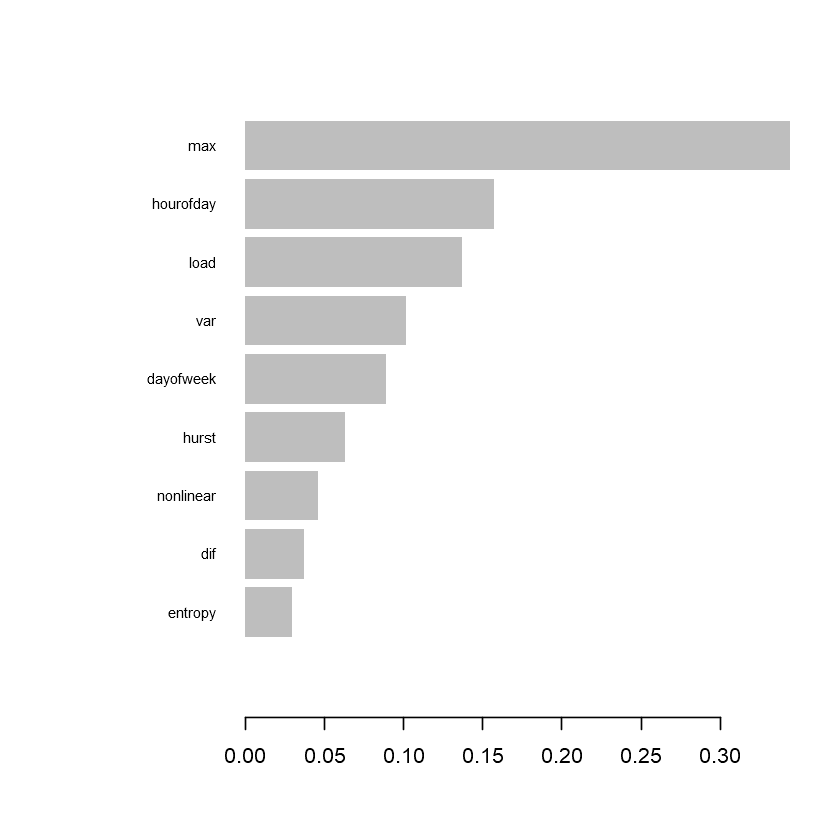

In [86]:
#view variable importance plot
mat <- xgb.importance (feature_names = colnames(train.dryer.xgb),model = xgboost_cv_dryer)
xgb.plot.importance (importance_matrix = mat[1:10])

In [ ]:
shap_values <- shap.prep(xgb_model = xgb_model_dryer, X_train = data.dryer.xgb$train.xbg)
shap.plot.summary(shap_values, scientific = TRUE)

## Submission File

In [87]:
col_index = test.dataset[,1]
submission <- function(ac, ev, oven, wash, dryer){
     
    submission <- data.frame(col_index,ac, ev, oven, wash, dryer)
    return(submission)
}
pred_labels <- submission(ac, ev, oven, wash, dryer)
write.csv(pred_labels,"./pred_labels.csv", row.names = FALSE)

## Kaggle File

In [101]:
id = test.dataset[,1]
submission <- function(ac, ev, oven, wash, dryer){
     
    submission <- data.frame(id,ac, ev, oven, wash, dryer)
    return(submission)
}
pred_labels <- submission(ac, ev, oven, wash, dryer)
write.csv(pred_labels,"./kaggle.csv", row.names = FALSE)